In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pointbiserialr
from datetime import timedelta

# Function to dynamically identify health-related columns
def identify_health_labels(df, exclude_cols=['cow', 'date', 'IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL', 'hour']):
    # Identify columns that are likely binary health indicators
    potential_health_cols = [col for col in df.columns if col not in exclude_cols]
    health_labels = [col for col in potential_health_cols 
                    if df[col].dropna().isin([0, 1]).all()]
    return health_labels

c:\Users\lamia\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


**Load the dataset**

In [2]:
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    return df

### **Dataset First View**

In [3]:
def display_dataset_head(df):
    return df.head()

### **Dataset Rows & Columns count**

In [4]:
def print_dataset_shape(df):
    print("Number of rows are: ",df.shape[0])
    print("Number of columns are: ",df.shape[1])

**Displaying Column Names**

In [5]:
def display_column_names(df):
    print(df.columns)

**Define behavioral and health-related features**

In [6]:
def define_features(df):
    behavioral_features = ['IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL']
    health_indicators = identify_health_labels(df)
    return behavioral_features, health_indicators

**Distribution of health states**

In [26]:
def plot_health_states_distribution(df):
    health_states = identify_health_labels(df)
    if not health_states:
        print("No health states identified in the dataset.")
        return
    df_health = df[health_states]
    health_counts = df_health.sum().sort_values(ascending=False)
    total = len(df)
    health_percent = (health_counts / total) * 100

    safe_health_percent = health_percent.copy()
    safe_health_percent[safe_health_percent == 0] = 0.01

    plt.figure(figsize=(12, 6))
    bars = plt.bar(safe_health_percent.index, safe_health_percent.values, color='lightcoral')

    for i, bar in enumerate(bars):
        original = health_percent.values[i]
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                 f'{original:.2f}%', ha='center', va='bottom')

    plt.yscale('log')
    plt.title('Proportion of Health States (Log Scale)', fontweight='bold')
    plt.xlabel('Health States', fontweight='bold')
    plt.ylabel('Percentage (log scale)', fontweight='bold')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7, which='both')
    plt.tight_layout()
    plt.show()

**Unique Value Counts per Event**

In [8]:
def print_unique_value_counts(df):
    target_columns = identify_health_labels(df)
    print("Unique Value Counts per Event:")
    for col in target_columns:
        value_counts = df[col].value_counts()
        print(f"{col}:")
        print(value_counts)
        print("---------------------------------")

**Count the number of cows in the dataset**

In [9]:
def count_unique_cows(df):
    num_cows = df['cow'].nunique()
    print(f"Total number of unique cows: {num_cows}")

**Display the ids of cows**

In [10]:
def display_cow_ids(df):
    unique_cow_ids = df['cow'].unique()
    print("List of unique cow IDs:")
    print(unique_cow_ids)  # Prints all IDs as an array

    sorted_cow_ids = sorted(df['cow'].unique())
    print("\nSorted list of cow IDs:")
    print(sorted_cow_ids)

**Duplicate Values**

In [11]:
def check_duplicates(df):
    # Dataset Duplicate Value Count
    dup = df.duplicated().sum()
    print(f'number of duplicated rows are {dup}')

**Missing Values**

In [12]:
def check_missing_values(df):
    # Missing Values/Null Values Count
    return df.isnull().sum()

**Matrix of missing values**

In [13]:
def plot_missing_values_matrix(file_path):
    data = pd.read_csv(file_path)

    plt.figure(figsize=(15, 8))
    msno.matrix(data, color=(0, 0.5, 0.5))  # Affichage des valeurs manquantes en matrice
    plt.title("Matrice des valeurs manquantes", fontsize=18, fontweight='bold')
    plt.show()

**Outliers detection**

Détails du calcul théorique :

1. Plage minimale ( -828 ) :

Si une vache passe 1 heure entière (3600 secondes) au repos : -0.23 * 3600 + 0.16 * 0 + 0.42 * 0 = -828

2. Plage maximale ( 1512 ) :

Si une vache passe 1 heure entière (3600 secondes) à manger : -0.23 * 0 + 0.16 * 0 + 0.42 * 3600 = 1512

In [14]:
def detect_and_plot_outliers(df):
    min_theorique = -828
    max_theorique = 1512

    # Calculer les min/max observés
    min_obs = df['ACTIVITY_LEVEL'].min()
    max_obs = df['ACTIVITY_LEVEL'].max()

    print(f"Plage théorique : [{min_theorique}, {max_theorique}]")
    print(f"Plage observée  : [{min_obs:.2f}, {max_obs:.2f}]")

    # Identifier les valeurs hors plage
    outliers = df[(df['ACTIVITY_LEVEL'] < min_theorique) | (df['ACTIVITY_LEVEL'] > max_theorique)]
    num_outliers = len(outliers)

    plt.figure(figsize=(10, 6))
    plt.hist(df['ACTIVITY_LEVEL'], bins=50, color='skyblue', edgecolor='black')
    plt.axvline(x=min_theorique, color='red', linestyle='--', label='Borne min théorique')
    plt.axvline(x=max_theorique, color='green', linestyle='--', label='Borne max théorique')
    plt.xlabel('Niveau d\'activité')
    plt.ylabel('Fréquence')
    plt.title('Distribution des niveaux d\'activité')
    plt.legend()
    plt.xlim(-1000, 1600)  # Pour mieux visualiser les éventuels outliers
    plt.show()

    print("\n[ Rapport d'anomalies ]")
    print(f"- Valeurs hors plage théorique : {num_outliers} ({num_outliers/len(df)*100:.2f}% du dataset)")

    if num_outliers > 0:
        print("- Exemples de lignes problématiques :")
        print(outliers[['date', 'ACTIVITY_LEVEL']].head())
    else:
        print("- Aucune valeur hors plage détectée.")

In [15]:
def plot_histograms(df):
    # Plot histograms for the selected columns to understand their distributions
    cols = ['IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL']
    df[cols].hist(bins=20, figsize=(12, 10))
    plt.suptitle("Data Distribution")
    plt.show()

**Visualization of Health States Proportions**

In [16]:
def plot_health_states_proportions(file_path):
    df = pd.read_csv(file_path)
    health_states = identify_health_labels(df)
    if not health_states:
        print("No health states identified in the dataset.")
        return

    df_health = df[health_states]
    health_counts = df_health.sum().sort_values(ascending=False)
    total = len(df)
    health_percent = (health_counts / total) * 100

    plt.figure(figsize=(12, 6))
    bars = plt.bar(health_percent.index, health_percent.values, color='lightcoral')

    # Formatting: 2 decimal places
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%',  # .2f = 2 decimal places
                 ha='center', va='bottom')

    plt.title('Proportion of Health States (in %)', fontweight='bold')
    plt.xlabel('Health States', fontweight='bold')
    plt.ylabel('Percentage', fontweight='bold')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

**Missing hours**

In [17]:
def plot_missing_hours(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)

    # Ensure the datetime column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Count the number of observations (rows) per cow per day
    obs_counts = df.groupby(['cow', 'date']).size().reset_index(name='hour_count')

    # Identify rows with missing hours (less than 24)
    missing_obs = obs_counts[obs_counts['hour_count'] < 24]

    # Create a plot showing missing hour count per cow
    plt.figure(figsize=(12, 6))
    missing_obs.groupby('cow')['hour_count'].apply(lambda x: (24 - x).sum()).sort_values(ascending=False).plot(kind='bar')
    plt.title("Total Missing Hours per Cow (only cows with missing 24h records)")
    plt.xlabel("Cow ID")
    plt.ylabel("Total Missing Hours")
    plt.tight_layout()
    plt.show()

**Check Date Range and Missing Dates**

In [18]:
def check_date_range(df):
    # Convert 'date' to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Get min/max dates
    min_date = df['date'].min()
    max_date = df['date'].max()
    print(f"Date range: {min_date} to {max_date}")

    # Generate all expected dates in the range
    all_dates = pd.date_range(start=min_date, end=max_date, freq='D')
    print(f"Total expected days: {len(all_dates)}")

    # Check missing dates
    missing_dates = all_dates.difference(df['date'].unique())
    print(f"\nMissing dates {len(missing_dates)}:", ', '.join(missing_dates.strftime('%Y-%m-%d')))

**Analysis of Cows with Multiple Diseases**

In [19]:
def analyze_multiple_diseases(df):
    maladie_cols = [col for col in identify_health_labels(df) if col != 'OK']
    if not maladie_cols:
        print("No disease columns identified in the dataset.")
        return

    df_non_ok = df[df['OK'] == 0].copy()

    df_non_ok['nb_maladies'] = df_non_ok[maladie_cols].sum(axis=1)

    # Keep only rows with more than one disease
    multi_maladie = df_non_ok[df_non_ok['nb_maladies'] > 1].copy()

    # Extract the names of the diseases present
    def get_maladies_presentes(row):
        return [col for col in maladie_cols if row[col] == 1]

    multi_maladie['maladies_presentes'] = multi_maladie.apply(get_maladies_presentes, axis=1)

    # Display results
    print(f"Number of cases with multiple diseases: {len(multi_maladie)}")
    print(multi_maladie[['cow', 'date', 'hour', 'maladies_presentes']])

**Investigate the correlation between the "OK" label and other health states**

In [20]:
def check_ok_label_consistency(df):
    health_labels = [col for col in identify_health_labels(df) if col != 'OK']
    if not health_labels:
        print("No health labels (excluding OK) identified in the dataset.")
        return

    violations = df[(df['OK'] == 1) & (df[health_labels].sum(axis=1) > 0)]

    if violations.empty:
        print("✅ Aucun cas trouvé où OK == 1 et un état de santé est aussi à 1. Tout est cohérent.")
    else:
        print("⚠️ Des cas incohérents ont été trouvés ! Voici les lignes concernées :")
        print(violations)

**Correlation Analysis**

In [21]:
def perform_correlation_analysis(df):
    df = df.drop(columns=[col for col in ['cow', 'date', 'LPS', 'acidosis', 'ACTIVITY_LEVEL', 'hour'] if col in df.columns])

    # Define columns
    behavioral_features = ['IN_ALLEYS', 'REST', 'EAT']
    health_features = identify_health_labels(df)
    if not health_features:
        print("No health features identified in the dataset.")
        return

    # --- 1. Spearman Correlation between Behavioral Features ---
    behavior_corr = df[behavioral_features].corr(method='spearman')

    plt.figure(figsize=(6, 4))
    sns.heatmap(behavior_corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Spearman Correlation - Behavioral Features")
    plt.show()

    # --- 2. Pearson Correlation (Phi) between Health Features ---
    health_corr = df[health_features].corr(method='pearson')

    plt.figure(figsize=(10, 8))
    sns.heatmap(health_corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Phi Correlation (Pearson) - Health Features")
    plt.show()

    # --- 3. Point-Biserial Correlation: Behavioral vs Health States ---
    point_biserial_matrix = pd.DataFrame(index=health_features, columns=behavioral_features)

    for h in health_features:
        for b in behavioral_features:
            valid_data = df[[b, h]].dropna()
            if valid_data[h].nunique() > 1:  # Ensure variable is not constant
                corr, _ = pointbiserialr(valid_data[h], valid_data[b])
                point_biserial_matrix.loc[h, b] = corr
            else:
                point_biserial_matrix.loc[h, b] = np.nan

    point_biserial_matrix = point_biserial_matrix.astype(float)

    plt.figure(figsize=(8, 6))
    sns.heatmap(point_biserial_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Point-Biserial Correlation - Behavioral vs Health Features")
    plt.xlabel("Behavioral Features")
    plt.ylabel("Health Features")
    plt.show()

In [22]:
def plot_point_biserial_correlation(df):
    # Define columns
    behavioral_features = ['IN_ALLEYS', 'REST', 'EAT']
    health_features = identify_health_labels(df)
    if not health_features:
        print("No health features identified in the dataset.")
        return

    # Collect correlations
    correlation_data = []

    for h in health_features:
        for b in behavioral_features:
            valid_data = df[[b, h]].dropna()
            if valid_data[h].nunique() > 1:
                corr, pval = pointbiserialr(valid_data[h], valid_data[b])
                correlation_data.append({
                    'Health State': h,
                    'Behavioral Feature': b,
                    'Correlation': corr,
                    'p-value': pval
                })

    # Convert to DataFrame
    corr_df = pd.DataFrame(correlation_data)

    # Plot
    plt.figure(figsize=(8, 5))
    for health_state in corr_df["Health State"].unique():
        subset = corr_df[corr_df["Health State"] == health_state]
        plt.bar(subset["Behavioral Feature"] + f" ({health_state})", subset["Correlation"], label=health_state)

    plt.axhline(0, color='gray', linestyle='--')
    plt.title("Point-Biserial Correlation: Behavioral vs Health States")
    plt.ylabel("Correlation Coefficient")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [23]:
def plot_phi_correlation(df):
    if 'oestrus' in df.columns and 'OK' in df.columns:
        phi_corr = df[["oestrus", "OK"]].corr(method="pearson").iloc[0, 1]

        # Prepare plot
        plt.figure(figsize=(6, 3))
        x = ["oestrus vs OK"]
        y = [phi_corr]

        # Lollipop style plot
        plt.plot(x, y, marker='o', linestyle='-', color='steelblue')
        plt.axhline(0, color='gray', linestyle='--')
        plt.ylim(-1, 1)
        plt.title("Phi Correlation Between Binary Health Features")
        plt.ylabel("Correlation Coefficient")
        plt.grid(axis='y', linestyle=':')
        plt.tight_layout()
        plt.show()
    else:
        print("Columns 'oestrus' or 'OK' not found in the dataset.")


Analyzing C:/Users/lamia/Desktop/datasets/dataset1.csv

Dataset First View:

Dataset Rows & Columns count:
Number of rows are:  107665
Number of columns are:  19

Column Names:
Index(['cow', 'date', 'hour', 'IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL',
       'oestrus', 'calving', 'lameness', 'mastitis', 'LPS', 'acidosis',
       'other_disease', 'accidents', 'disturbance', 'mixing',
       'management_changes', 'OK'],
      dtype='object')

Distribution of Health States:


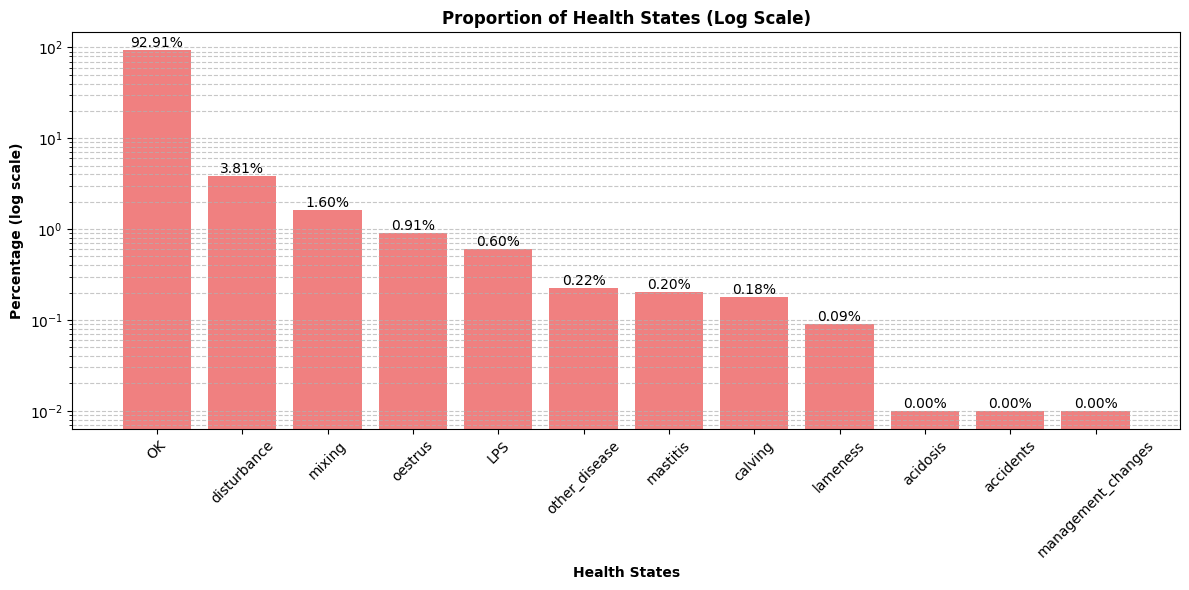


Unique Value Counts per Event:
Unique Value Counts per Event:
oestrus:
oestrus
0    106681
1       984
Name: count, dtype: int64
---------------------------------
calving:
calving
0    107473
1       192
Name: count, dtype: int64
---------------------------------
lameness:
lameness
0    107569
1        96
Name: count, dtype: int64
---------------------------------
mastitis:
mastitis
0    107449
1       216
Name: count, dtype: int64
---------------------------------
LPS:
LPS
0    107017
1       648
Name: count, dtype: int64
---------------------------------
acidosis:
Series([], Name: count, dtype: int64)
---------------------------------
other_disease:
other_disease
0    107425
1       240
Name: count, dtype: int64
---------------------------------
accidents:
accidents
0    107665
Name: count, dtype: int64
---------------------------------
disturbance:
disturbance
0    103559
1      4106
Name: count, dtype: int64
---------------------------------
mixing:
mixing
0    105937
1      1728


<Figure size 1500x800 with 0 Axes>

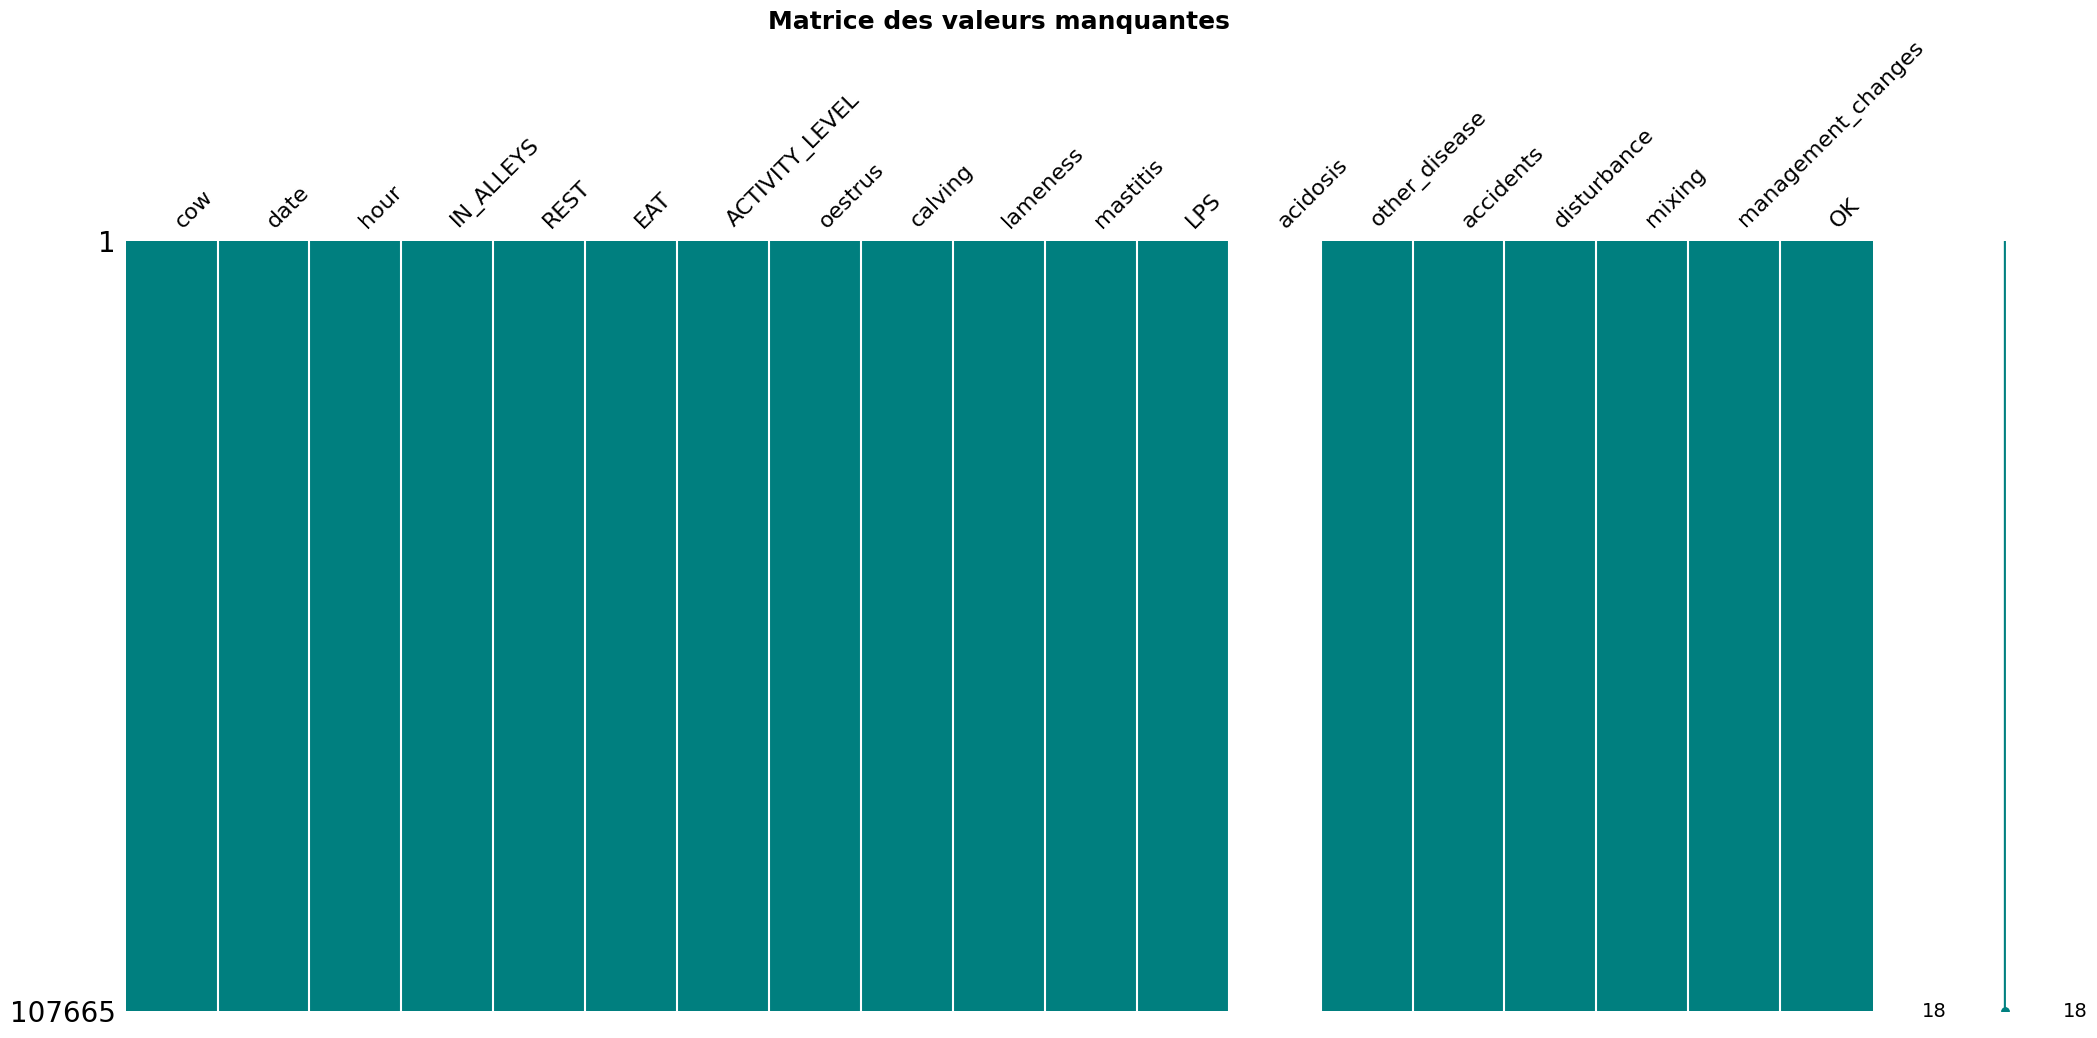


Outliers Detection:
Plage théorique : [-828, 1512]
Plage observée  : [-828.00, 1512.00]


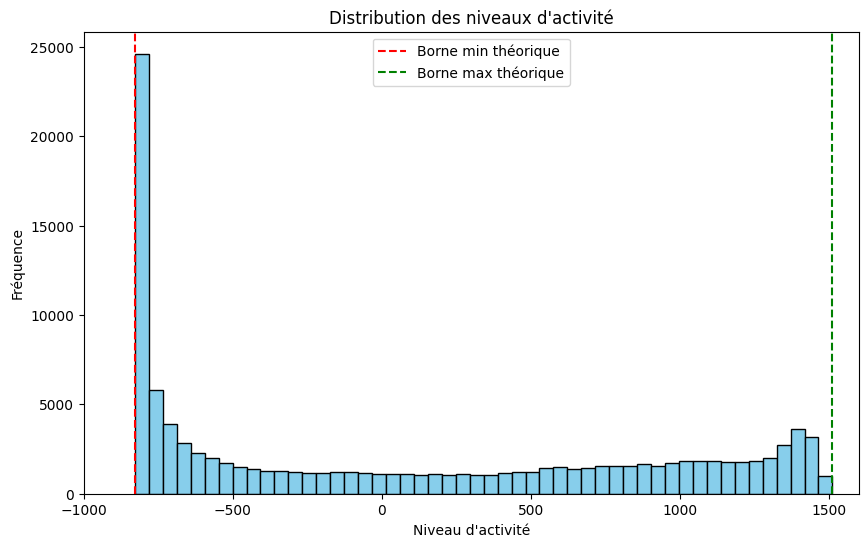


[ Rapport d'anomalies ]
- Valeurs hors plage théorique : 0 (0.00% du dataset)
- Aucune valeur hors plage détectée.

Data Distribution Histograms:


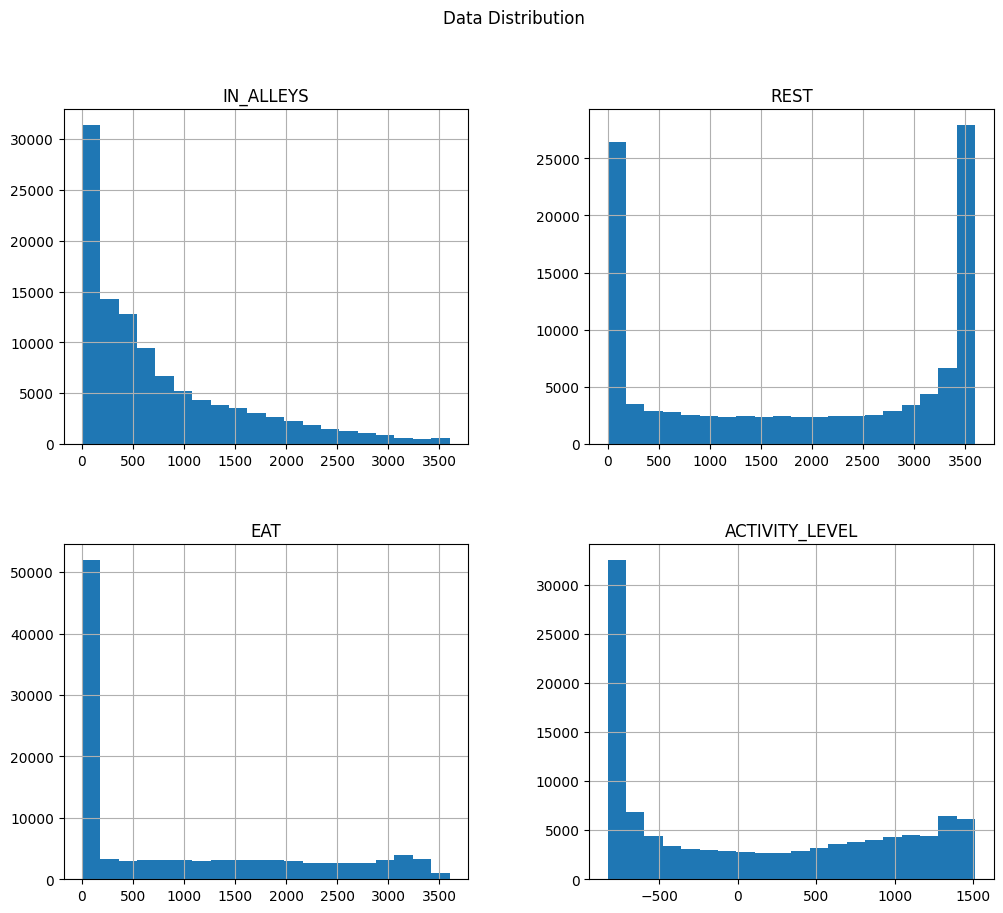


Health States Proportions:


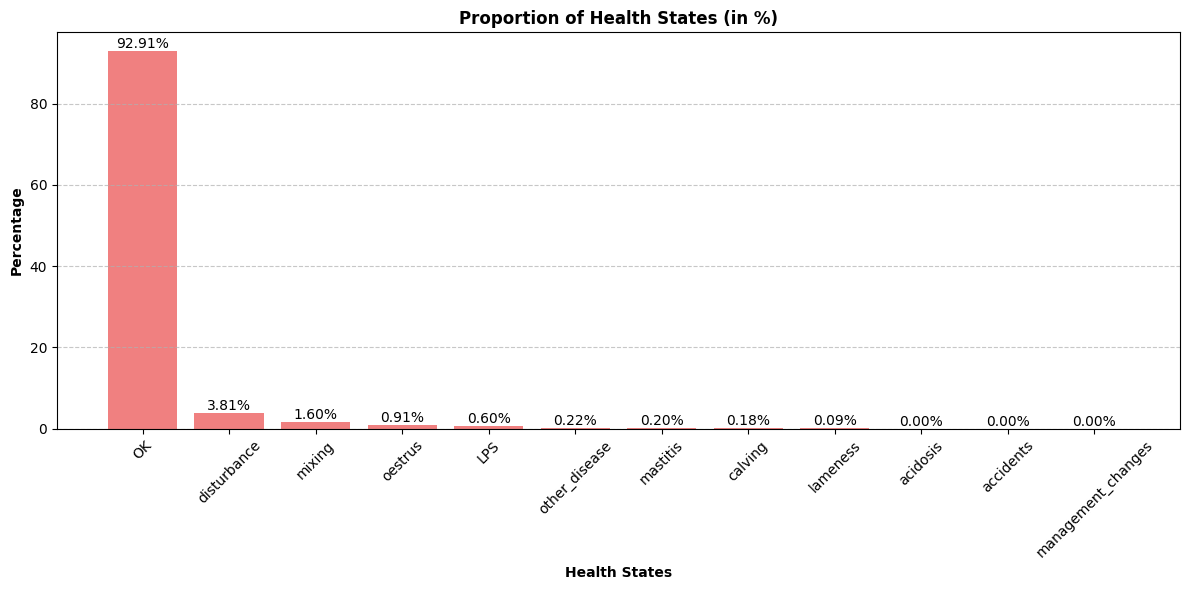


Missing Hours:


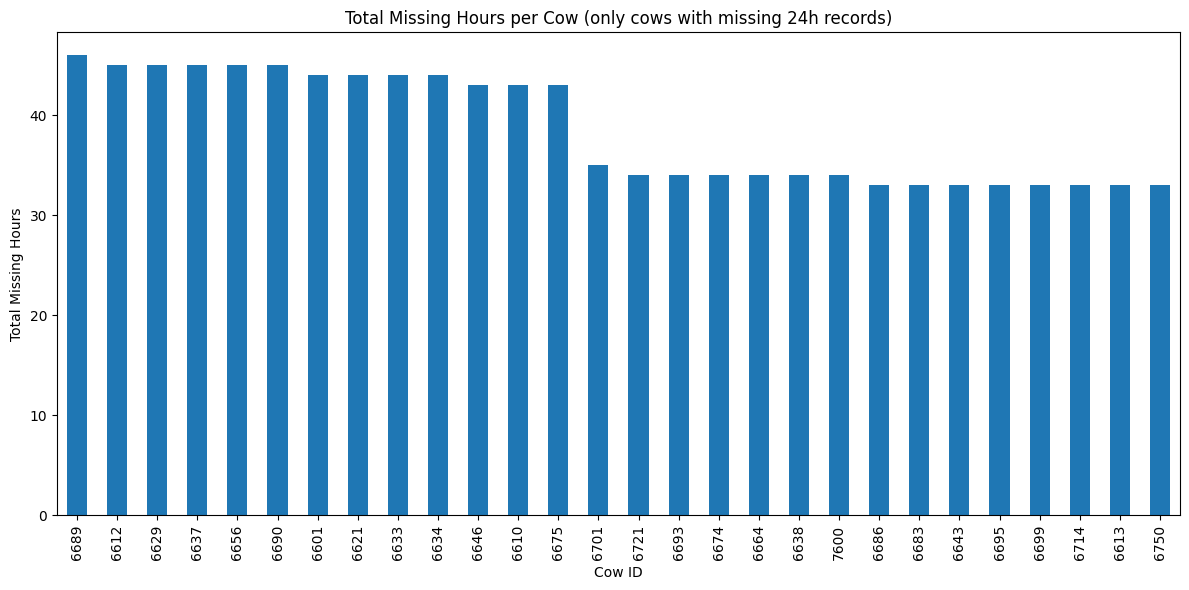


Date Range and Missing Dates:
Date range: 2018-10-25 00:00:00 to 2019-04-17 00:00:00
Total expected days: 175

Missing dates 3: 2019-01-25, 2019-01-26, 2019-01-27

Analysis of Cows with Multiple Diseases:
Number of cases with multiple diseases: 528
         cow       date  hour  maladies_presentes
6979    6610 2019-02-27     0  [LPS, disturbance]
6980    6610 2019-02-27     1  [LPS, disturbance]
6981    6610 2019-02-27     2  [LPS, disturbance]
6982    6610 2019-02-27     3  [LPS, disturbance]
6983    6610 2019-02-27     4  [LPS, disturbance]
...      ...        ...   ...                 ...
106494  7600 2019-02-27    19  [LPS, disturbance]
106495  7600 2019-02-27    20  [LPS, disturbance]
106496  7600 2019-02-27    21  [LPS, disturbance]
106497  7600 2019-02-27    22  [LPS, disturbance]
106498  7600 2019-02-27    23  [LPS, disturbance]

[528 rows x 4 columns]

OK Label Consistency Check:
✅ Aucun cas trouvé où OK == 1 et un état de santé est aussi à 1. Tout est cohérent.

Correlation 

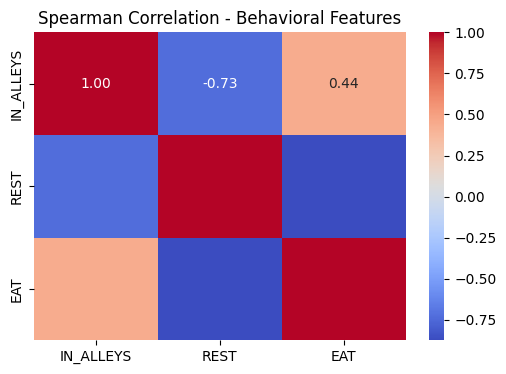

c:\Users\lamia\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


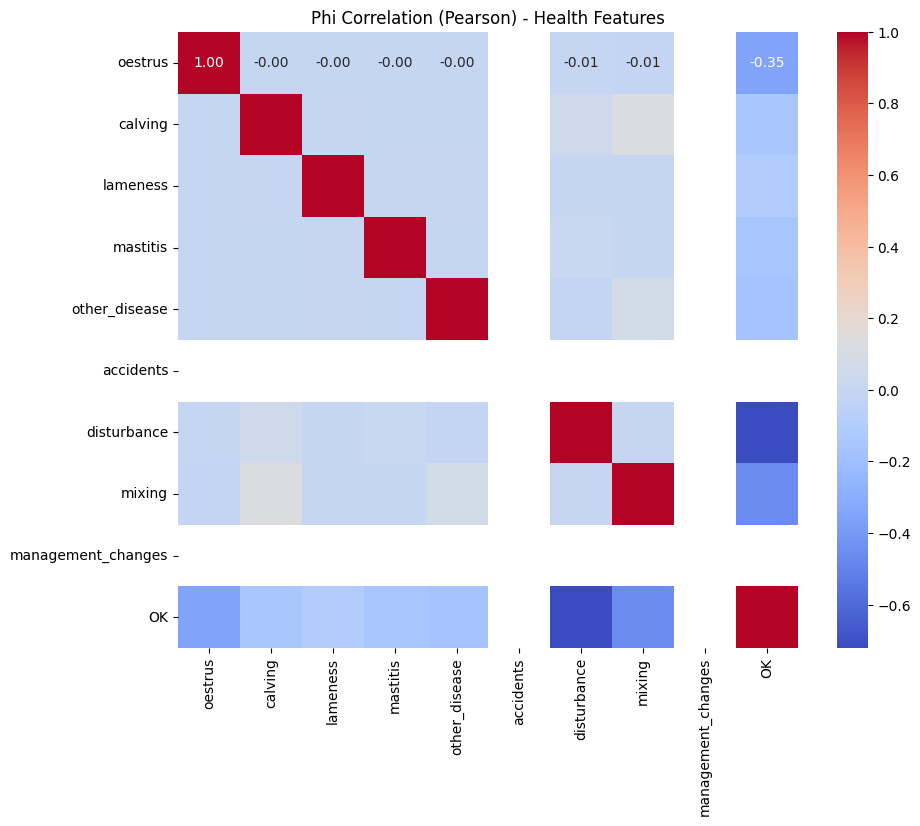

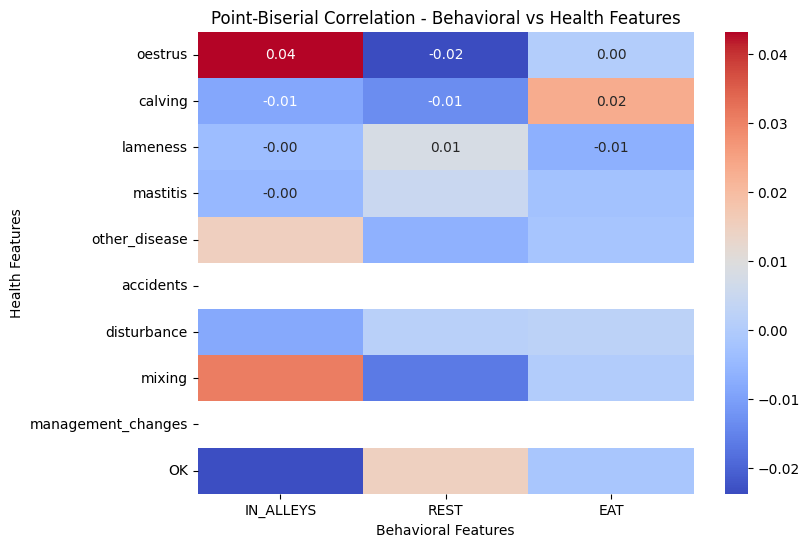


Point-Biserial Correlation Plot:


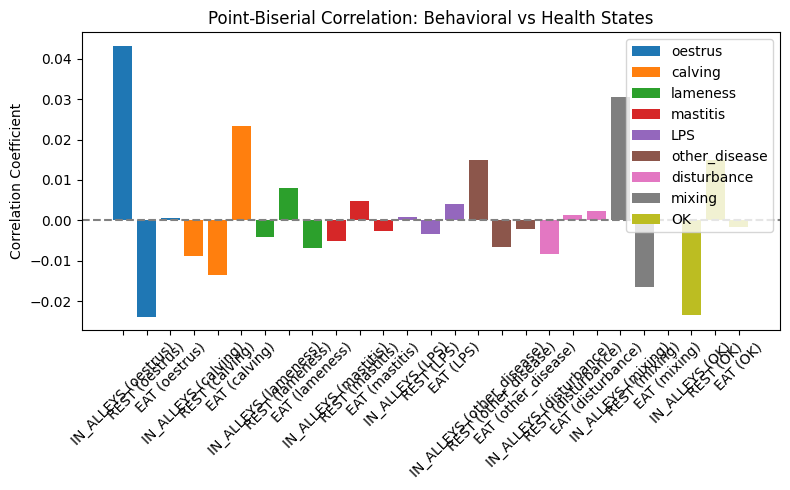


Phi Correlation:


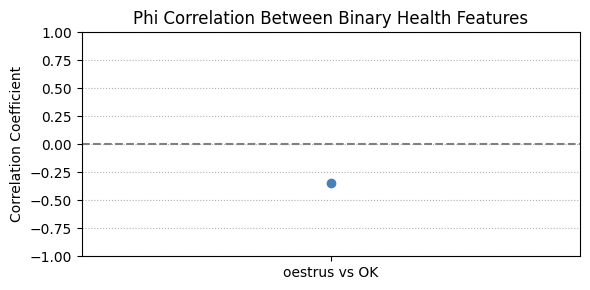


Analyzing C:/Users/lamia/Desktop/datasets/dataset2.csv

Dataset First View:

Dataset Rows & Columns count:
Number of rows are:  40247
Number of columns are:  19

Column Names:
Index(['cow', 'date', 'hour', 'IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL',
       'oestrus', 'calving', 'lameness', 'mastitis', 'LPS', 'acidosis',
       'other_disease', 'accidents', 'disturbance', 'mixing',
       'management_changes', 'OK'],
      dtype='object')

Distribution of Health States:


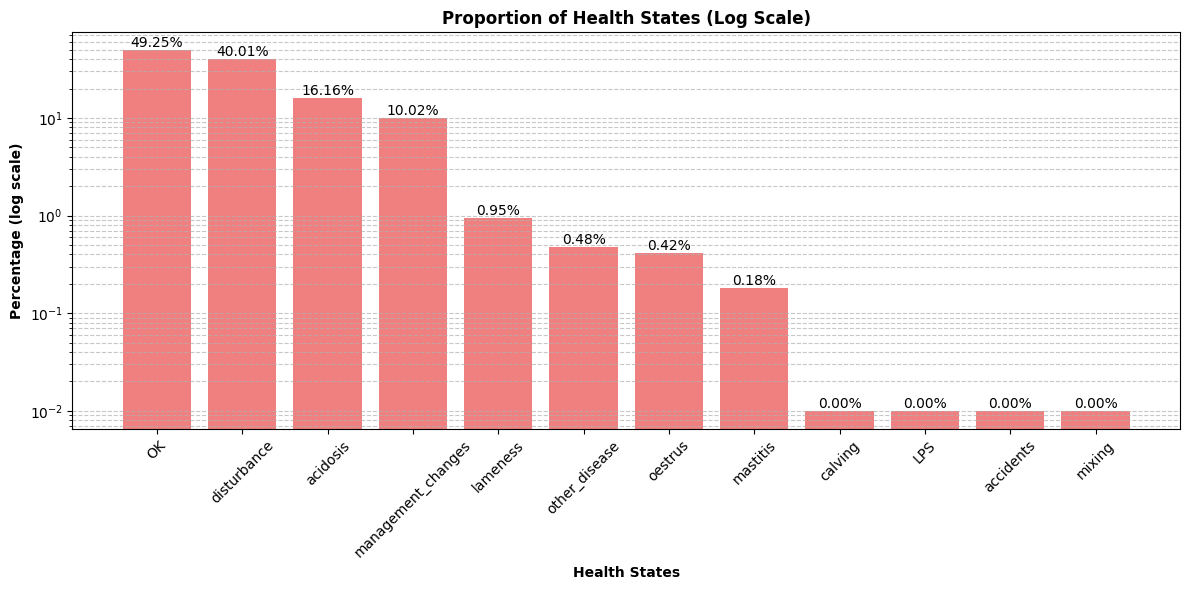


Unique Value Counts per Event:
Unique Value Counts per Event:
oestrus:
oestrus
0    40079
1      168
Name: count, dtype: int64
---------------------------------
calving:
calving
0    40247
Name: count, dtype: int64
---------------------------------
lameness:
lameness
0    39863
1      384
Name: count, dtype: int64
---------------------------------
mastitis:
mastitis
0    40175
1       72
Name: count, dtype: int64
---------------------------------
LPS:
Series([], Name: count, dtype: int64)
---------------------------------
acidosis:
acidosis
0    33743
1     6504
Name: count, dtype: int64
---------------------------------
other_disease:
other_disease
0    40055
1      192
Name: count, dtype: int64
---------------------------------
accidents:
accidents
0    40247
Name: count, dtype: int64
---------------------------------
disturbance:
disturbance
0    24143
1    16104
Name: count, dtype: int64
---------------------------------
mixing:
mixing
0    40247
Name: count, dtype: int64
--------

<Figure size 1500x800 with 0 Axes>

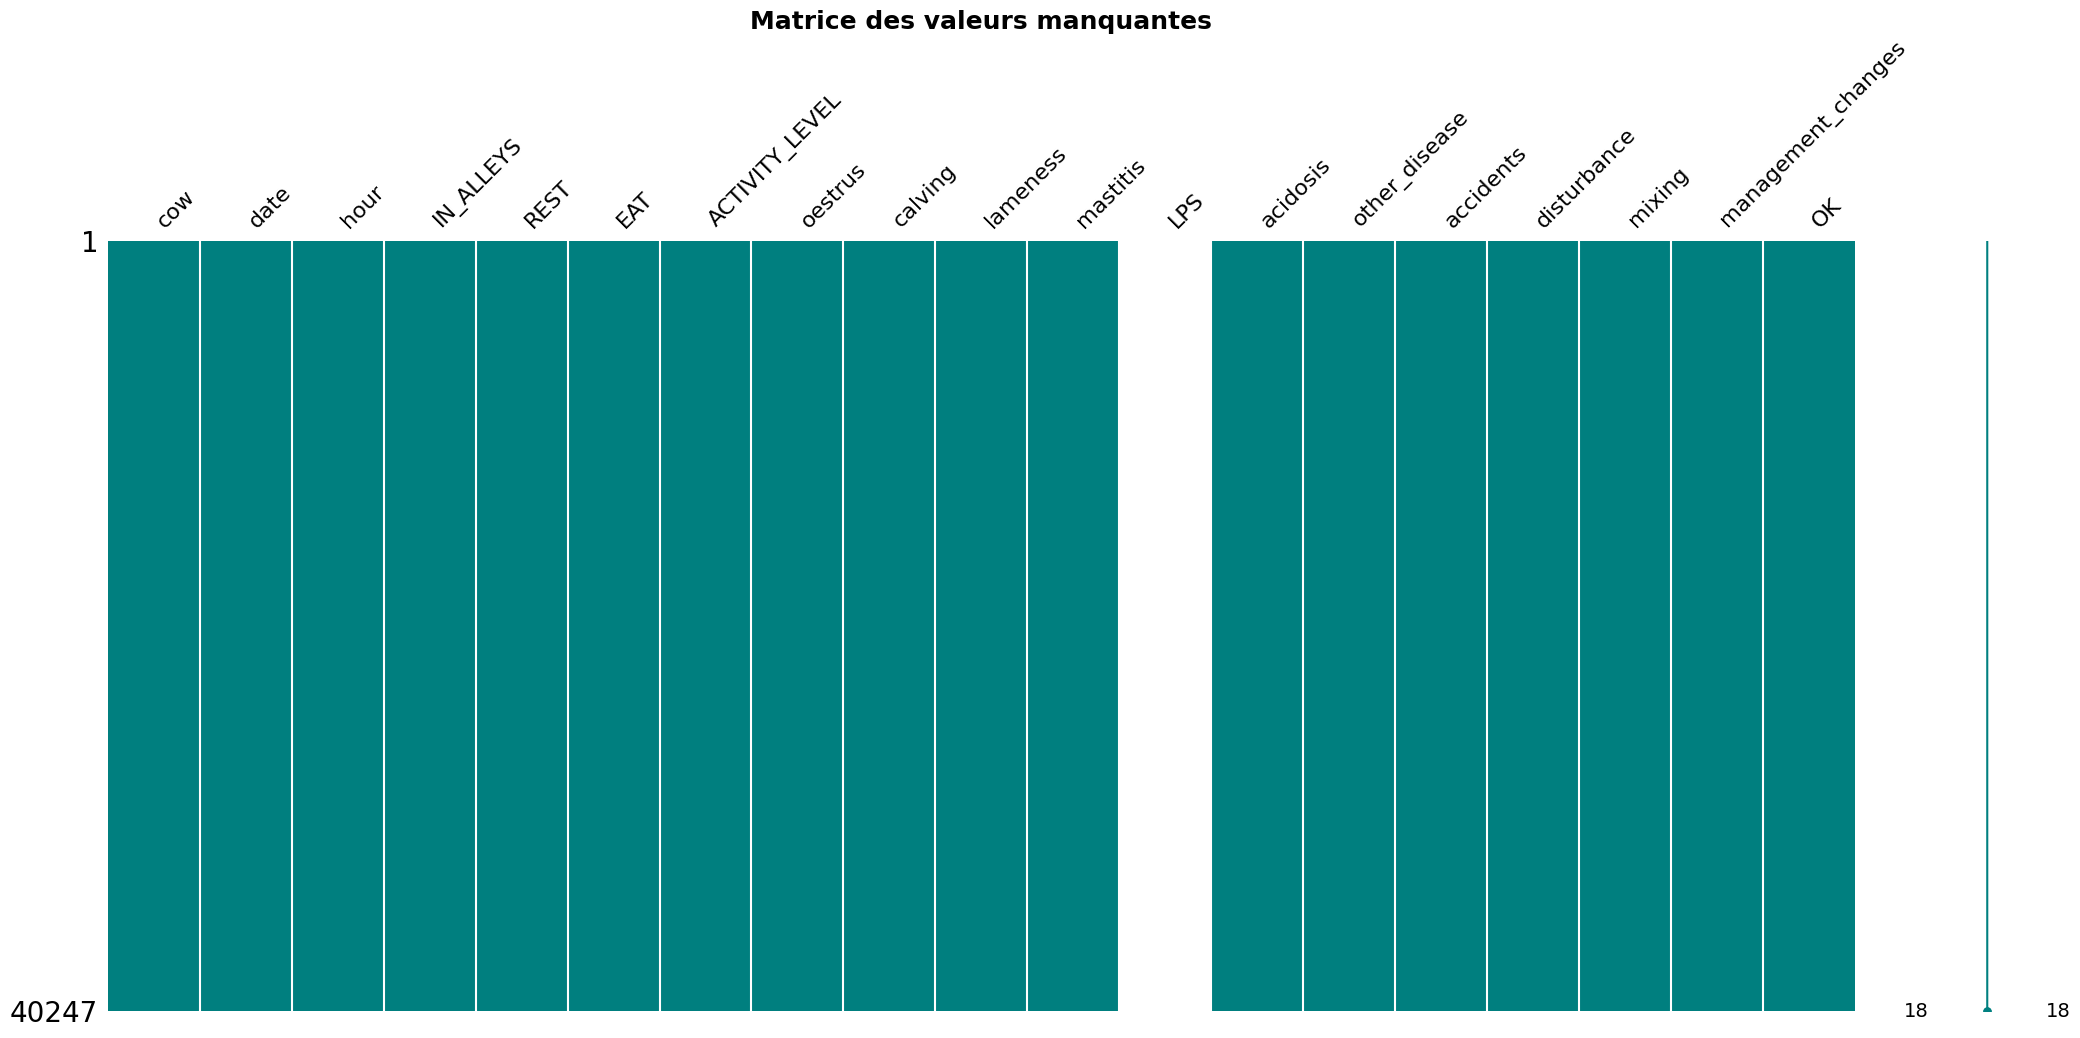


Outliers Detection:
Plage théorique : [-828, 1512]
Plage observée  : [-828.00, 1512.00]


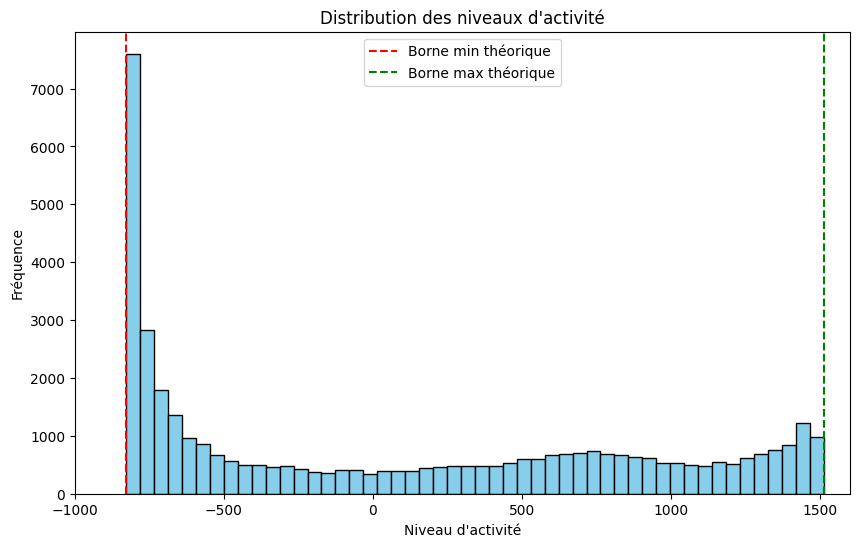


[ Rapport d'anomalies ]
- Valeurs hors plage théorique : 0 (0.00% du dataset)
- Aucune valeur hors plage détectée.

Data Distribution Histograms:


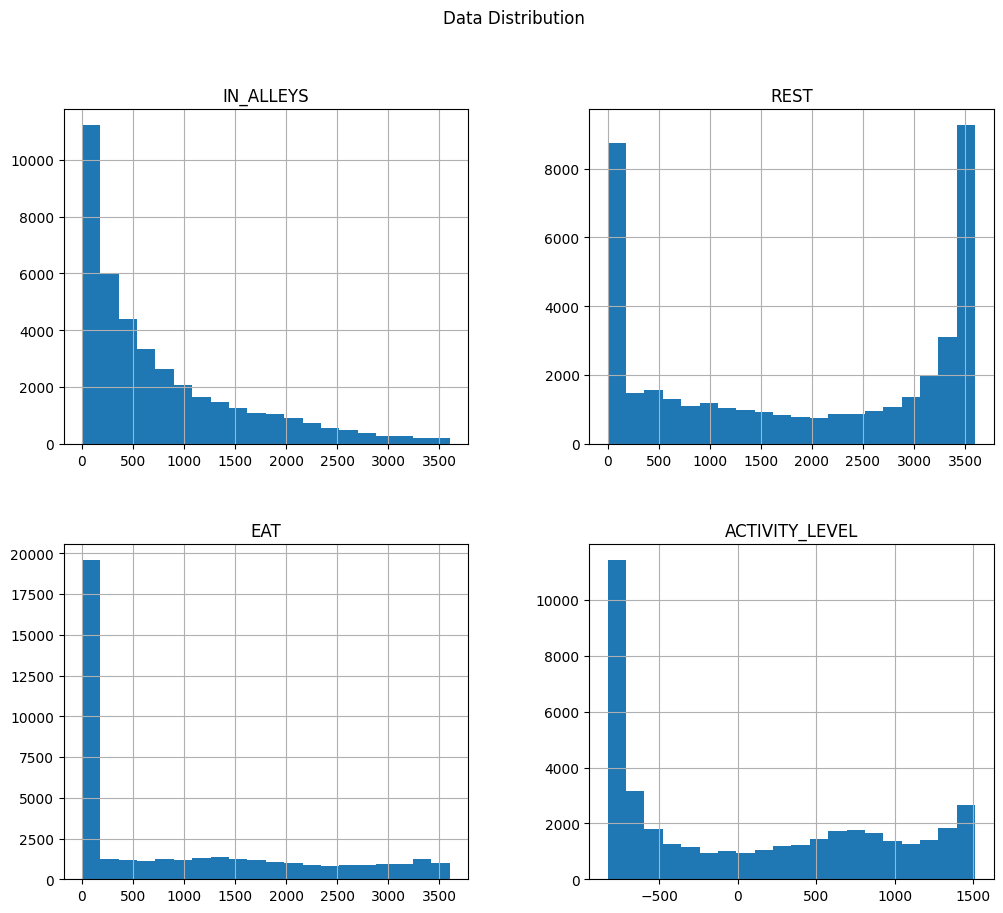


Health States Proportions:


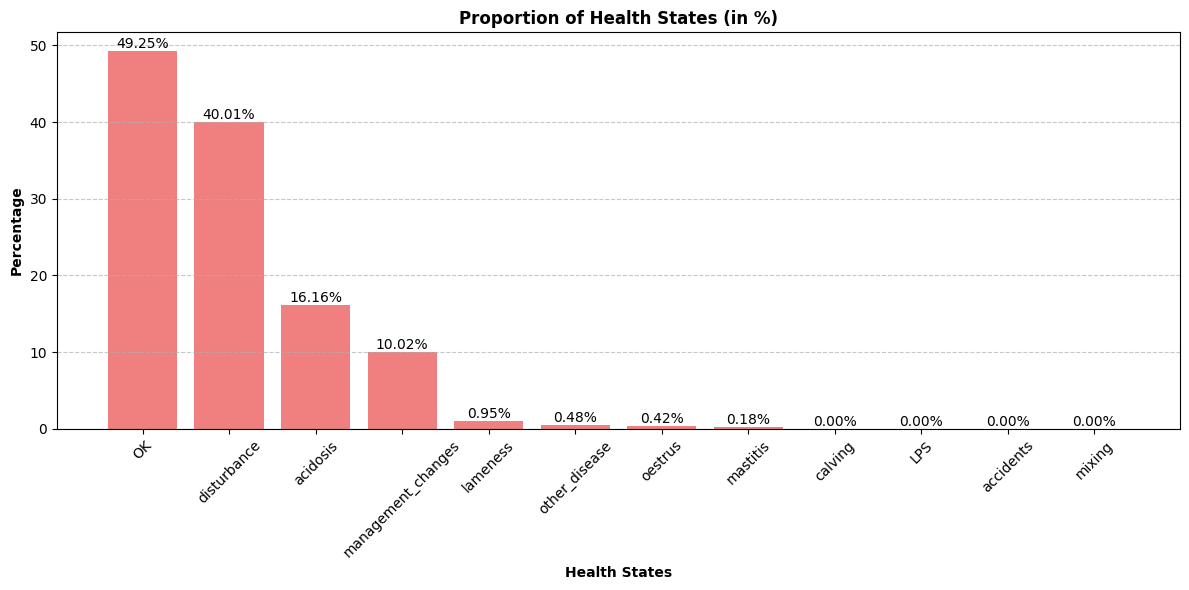


Missing Hours:


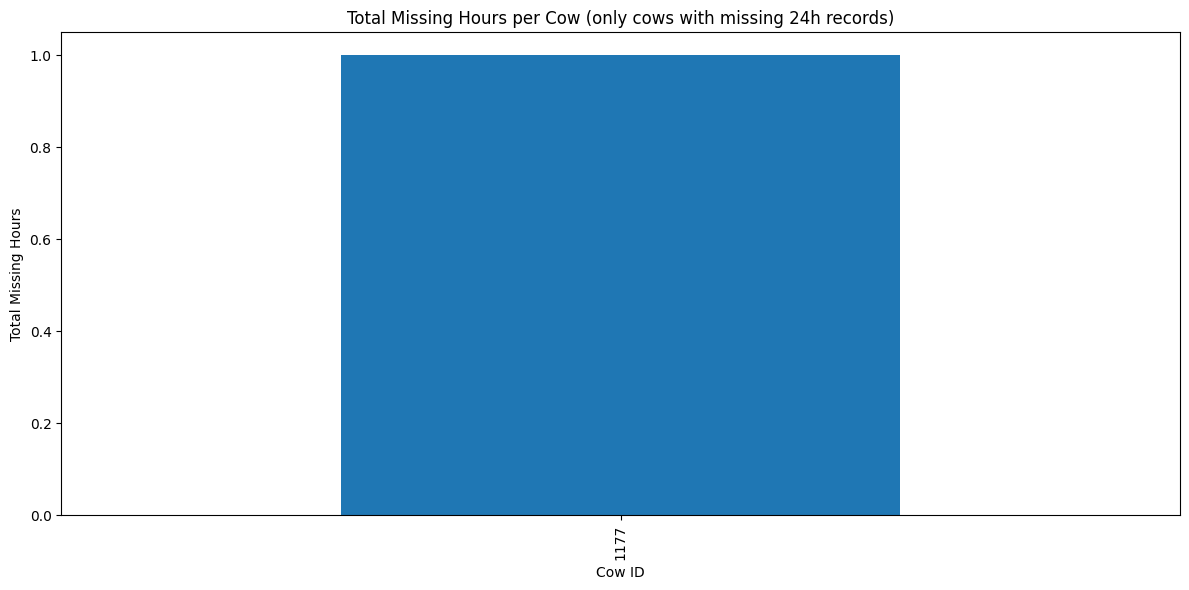


Date Range and Missing Dates:
Date range: 2015-03-02 00:00:00 to 2015-04-30 00:00:00
Total expected days: 60

Missing dates 0: 

Analysis of Cows with Multiple Diseases:
Number of cases with multiple diseases: 4776
        cow       date  hour              maladies_presentes
648    7163 2015-03-29     1  [acidosis, management_changes]
649    7163 2015-03-29     2  [acidosis, management_changes]
650    7163 2015-03-29     3  [acidosis, management_changes]
651    7163 2015-03-29     4  [acidosis, management_changes]
652    7163 2015-03-29     5  [acidosis, management_changes]
...     ...        ...   ...                             ...
40170  2622 2015-04-27    20         [acidosis, disturbance]
40171  2622 2015-04-27    21         [acidosis, disturbance]
40172  2622 2015-04-27    22         [acidosis, disturbance]
40173  2622 2015-04-27    23         [acidosis, disturbance]
40174  2622 2015-04-27    24         [acidosis, disturbance]

[4776 rows x 4 columns]

OK Label Consistency Check

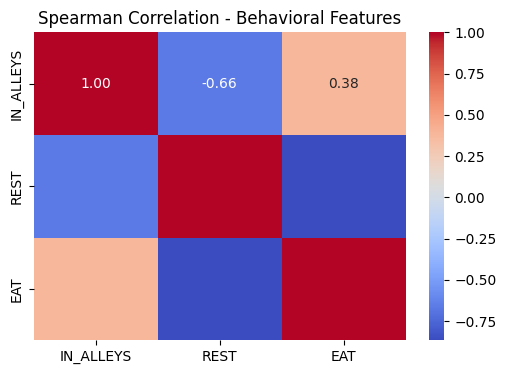

c:\Users\lamia\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


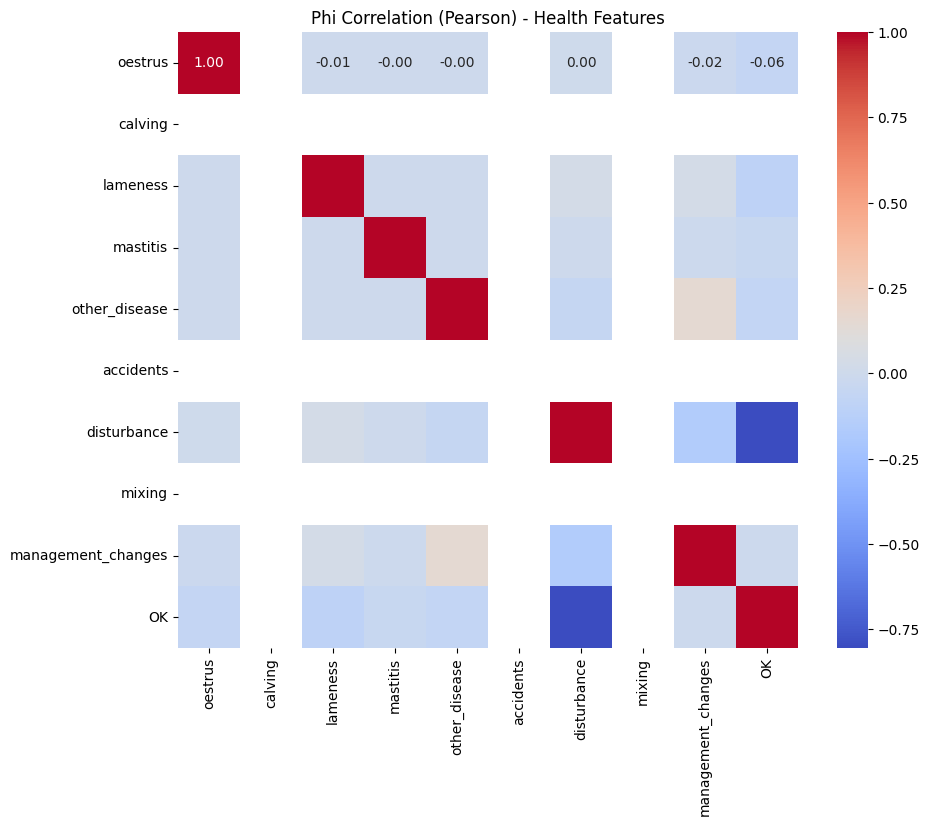

c:\Users\lamia\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


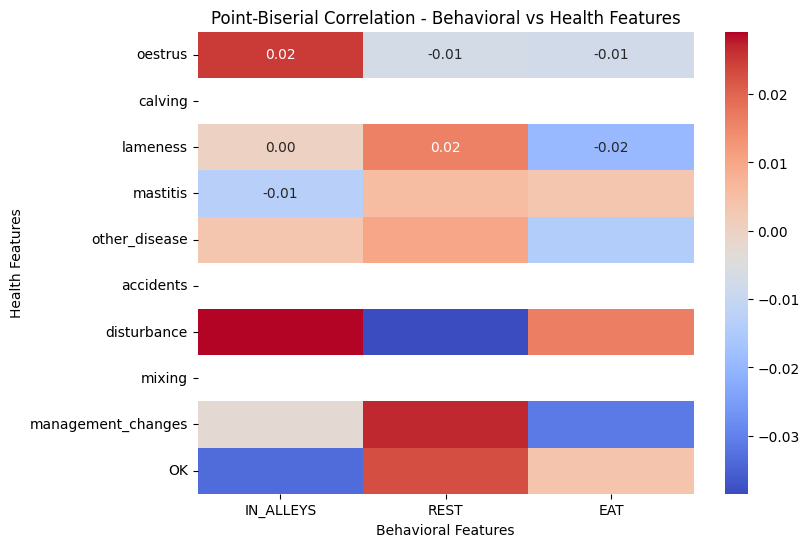


Point-Biserial Correlation Plot:


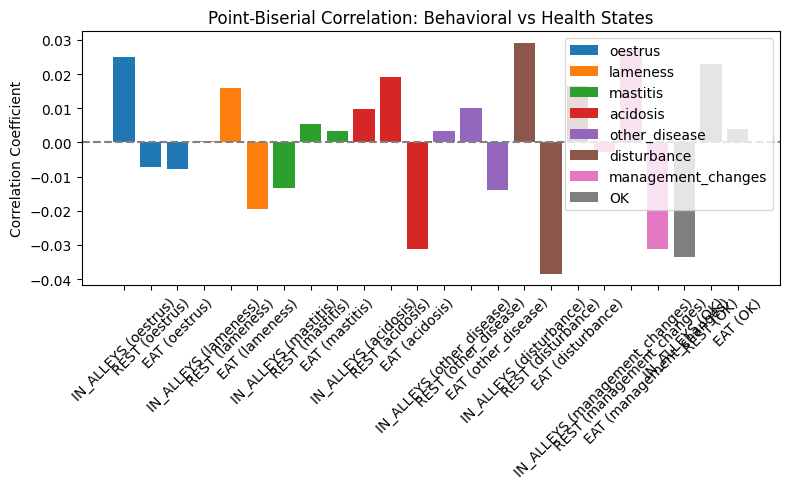


Phi Correlation:


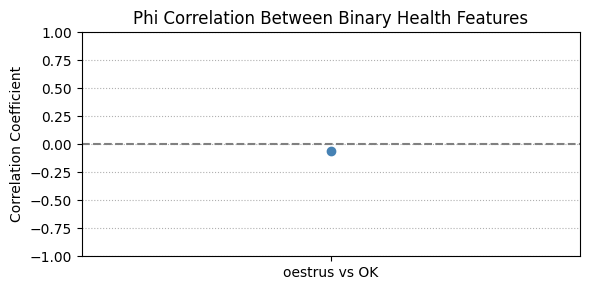


Analyzing C:/Users/lamia/Desktop/datasets/dataset3.csv

Dataset First View:

Dataset Rows & Columns count:
Number of rows are:  26225
Number of columns are:  19

Column Names:
Index(['cow', 'date', 'hour', 'IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL',
       'oestrus', 'calving', 'lameness', 'mastitis', 'LPS', 'acidosis',
       'other_disease', 'accidents', 'disturbance', 'mixing',
       'management_changes', 'OK'],
      dtype='object')

Distribution of Health States:


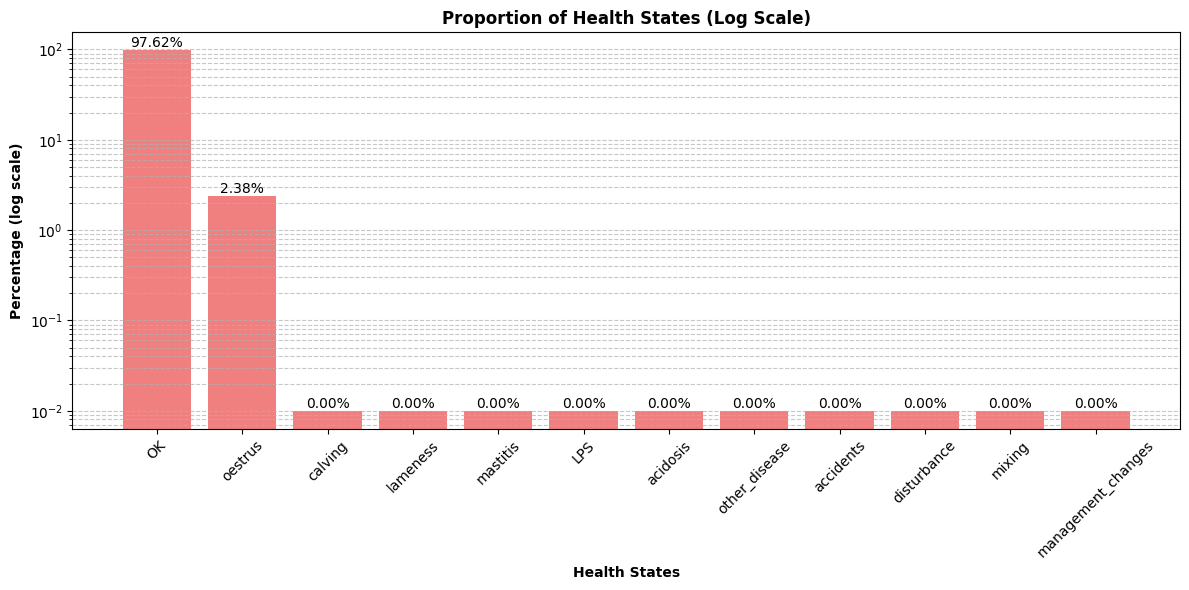


Unique Value Counts per Event:
Unique Value Counts per Event:
oestrus:
oestrus
0    25601
1      624
Name: count, dtype: int64
---------------------------------
calving:
calving
0    26225
Name: count, dtype: int64
---------------------------------
lameness:
lameness
0    26225
Name: count, dtype: int64
---------------------------------
mastitis:
mastitis
0    26225
Name: count, dtype: int64
---------------------------------
LPS:
Series([], Name: count, dtype: int64)
---------------------------------
acidosis:
Series([], Name: count, dtype: int64)
---------------------------------
other_disease:
other_disease
0    26225
Name: count, dtype: int64
---------------------------------
accidents:
accidents
0    26225
Name: count, dtype: int64
---------------------------------
disturbance:
disturbance
0    26225
Name: count, dtype: int64
---------------------------------
mixing:
mixing
0    26225
Name: count, dtype: int64
---------------------------------
management_changes:
management_change

<Figure size 1500x800 with 0 Axes>

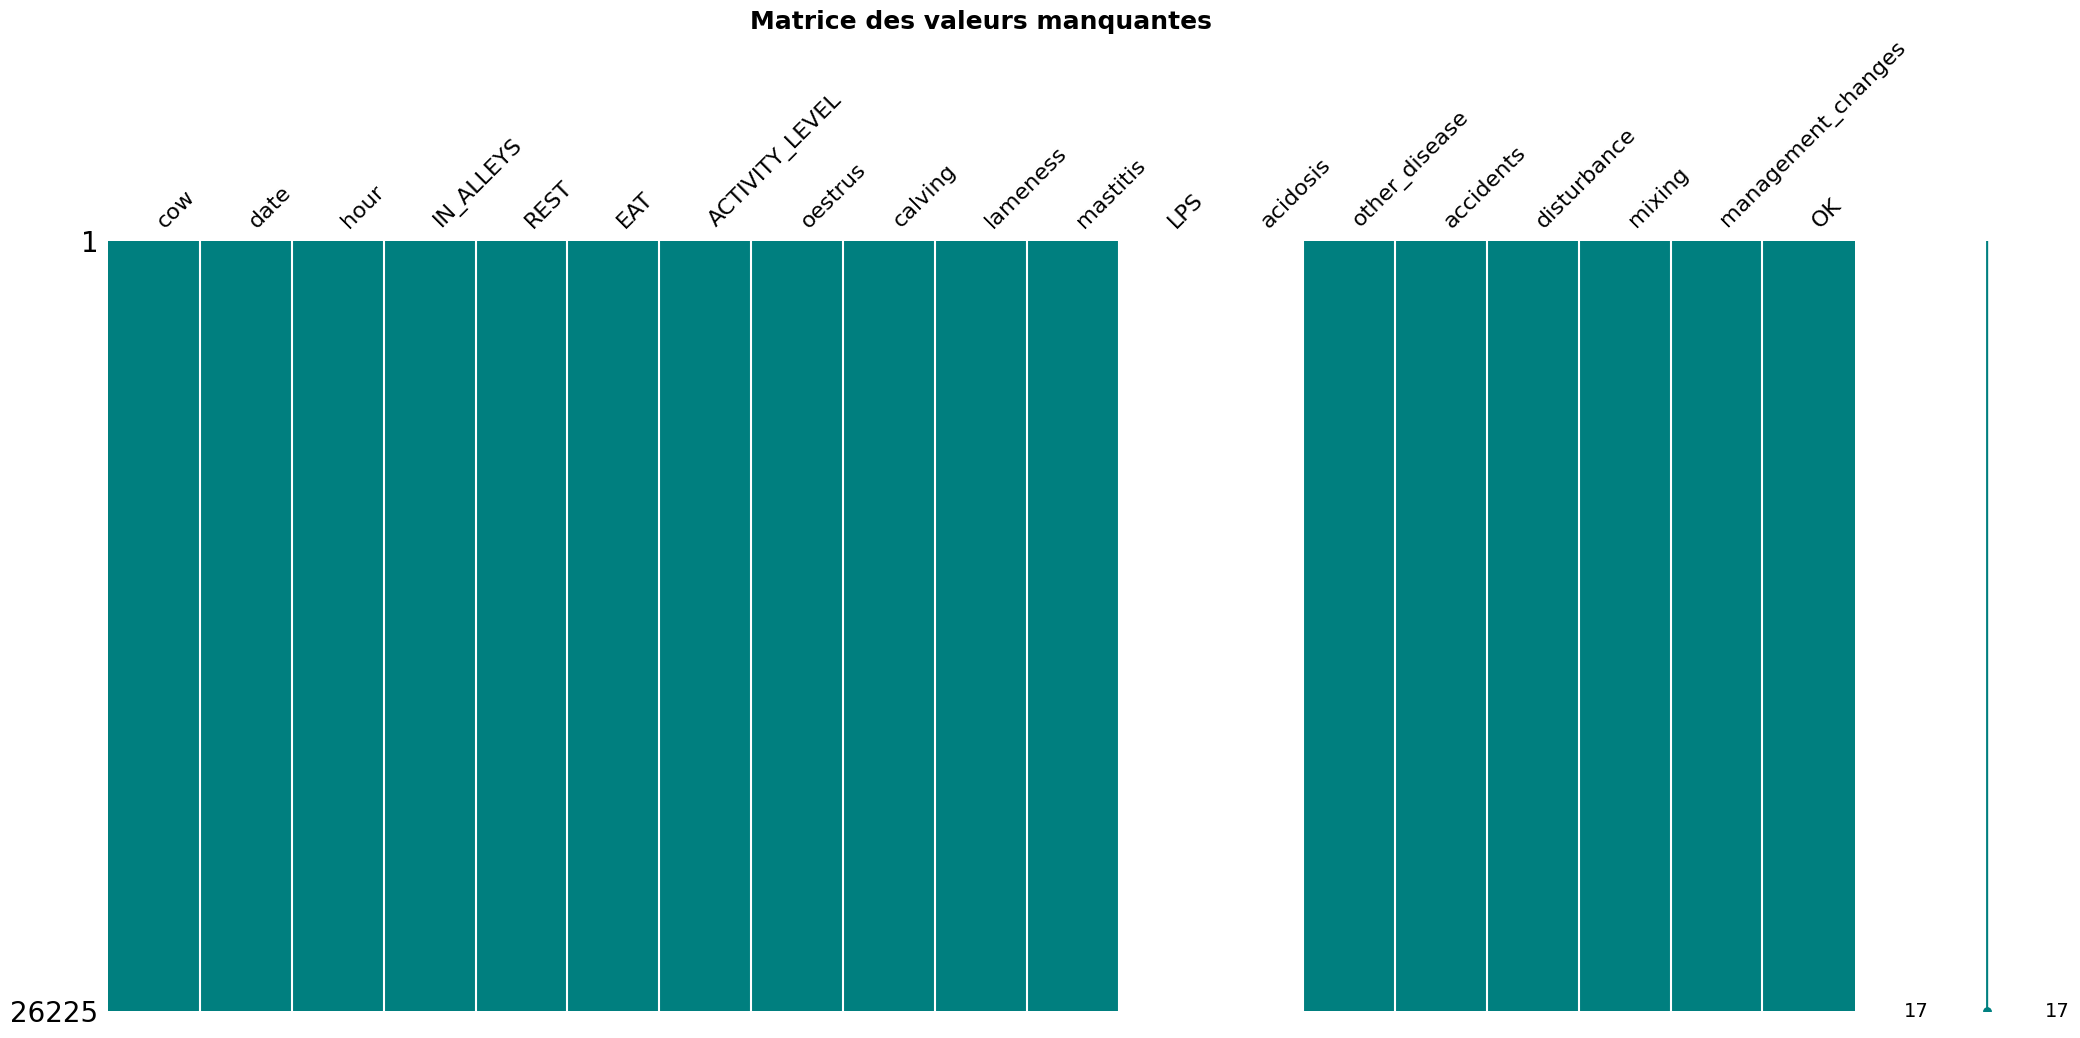


Outliers Detection:
Plage théorique : [-828, 1512]
Plage observée  : [-828.00, 1512.00]


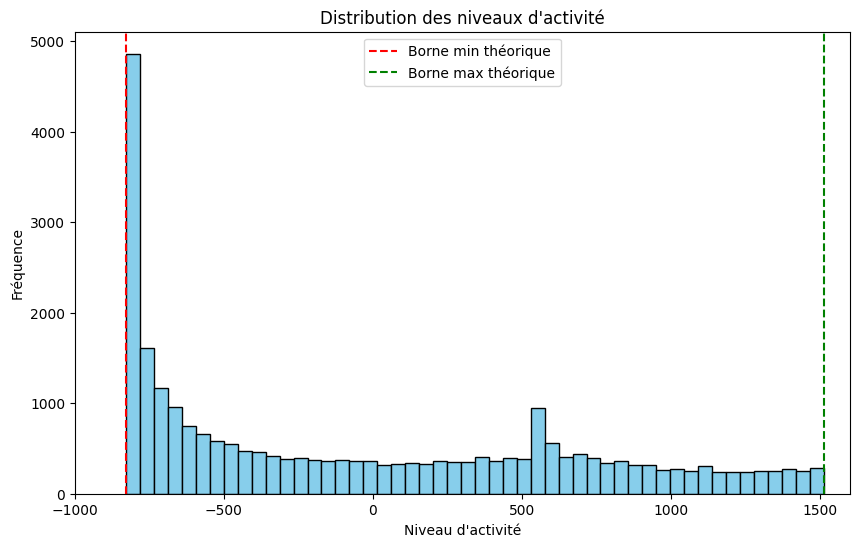


[ Rapport d'anomalies ]
- Valeurs hors plage théorique : 0 (0.00% du dataset)
- Aucune valeur hors plage détectée.

Data Distribution Histograms:


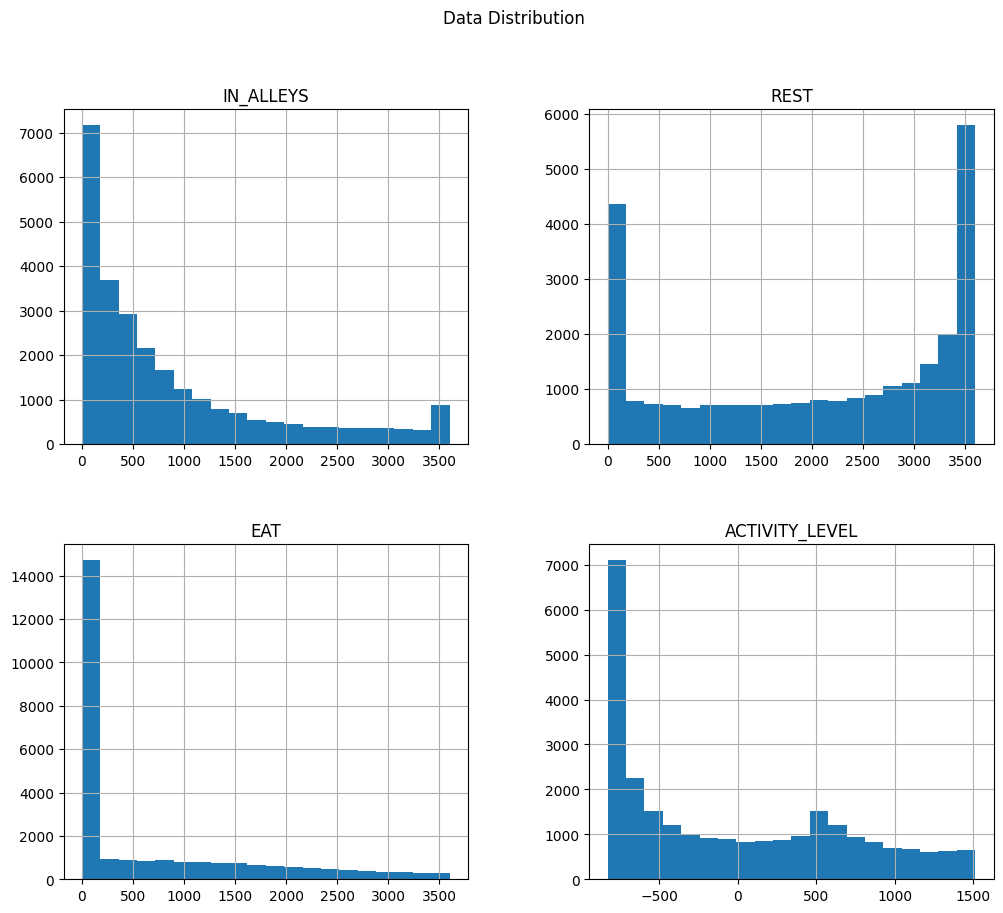


Health States Proportions:


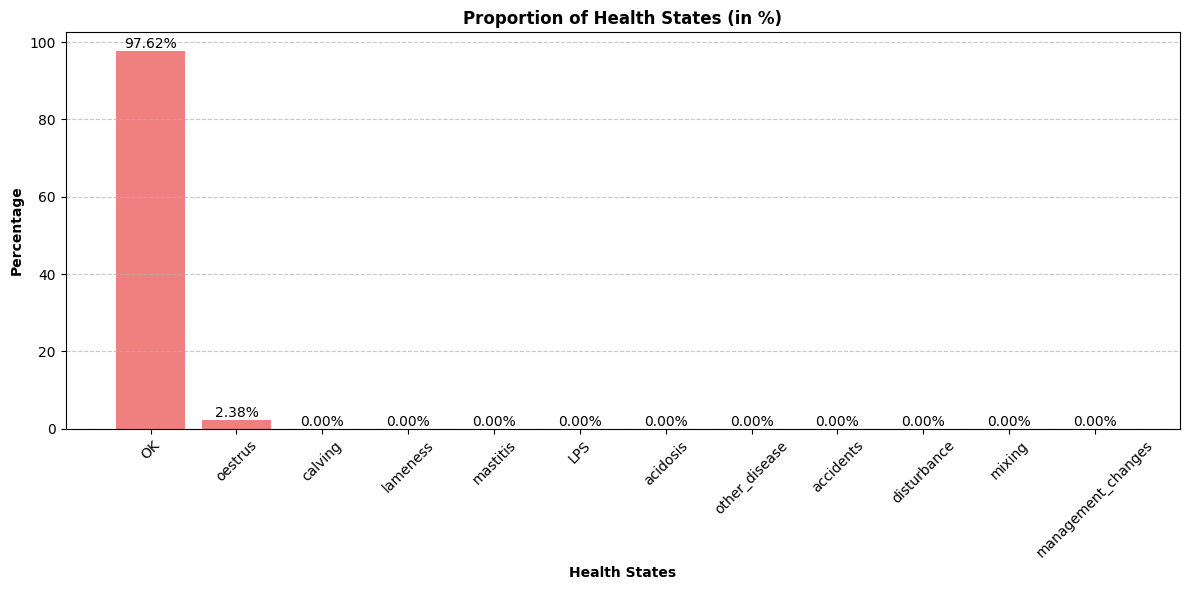


Missing Hours:


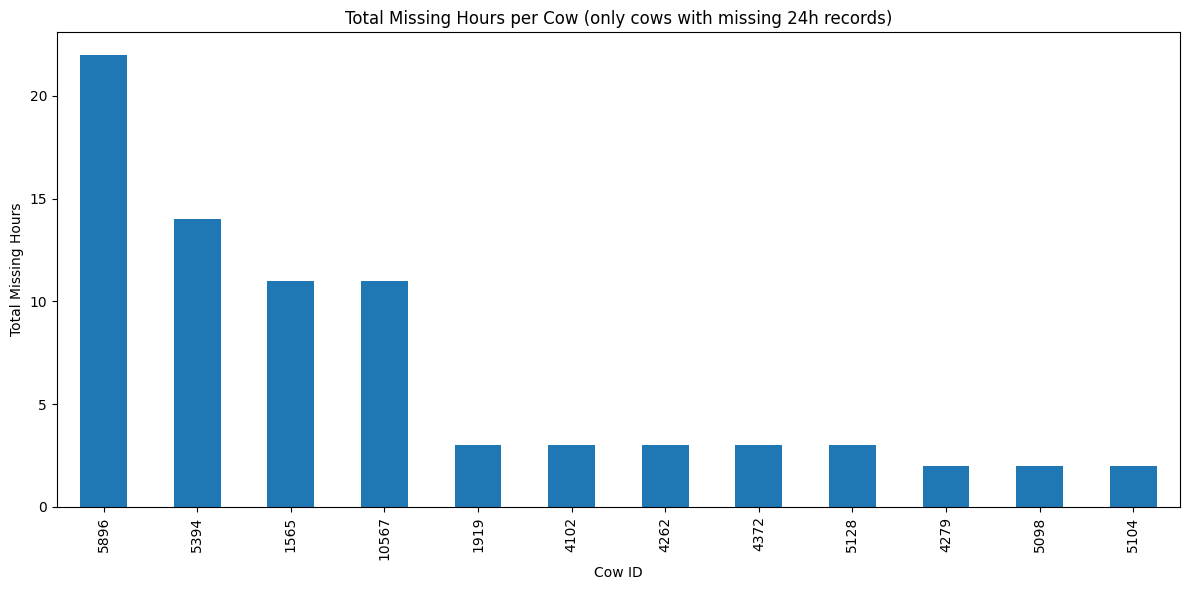


Date Range and Missing Dates:
Date range: 2013-10-01 00:00:00 to 2013-11-11 00:00:00
Total expected days: 42

Missing dates 0: 

Analysis of Cows with Multiple Diseases:
Number of cases with multiple diseases: 0
Empty DataFrame
Columns: [cow, date, hour, maladies_presentes]
Index: []

OK Label Consistency Check:
✅ Aucun cas trouvé où OK == 1 et un état de santé est aussi à 1. Tout est cohérent.

Correlation Analysis:


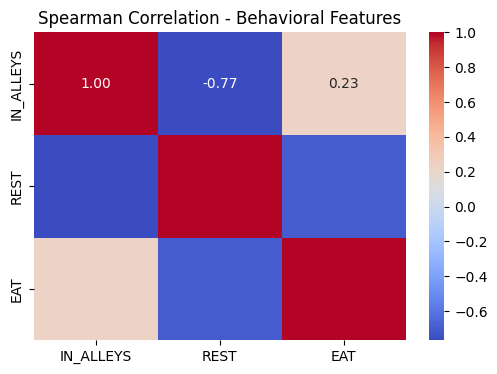

c:\Users\lamia\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


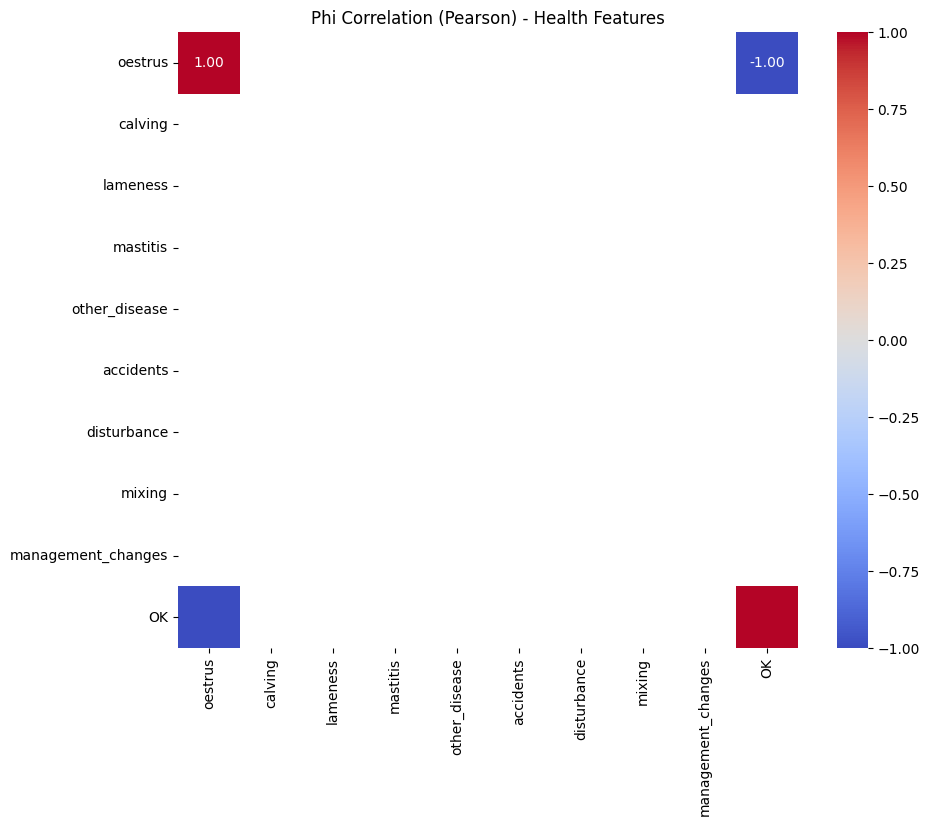

c:\Users\lamia\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


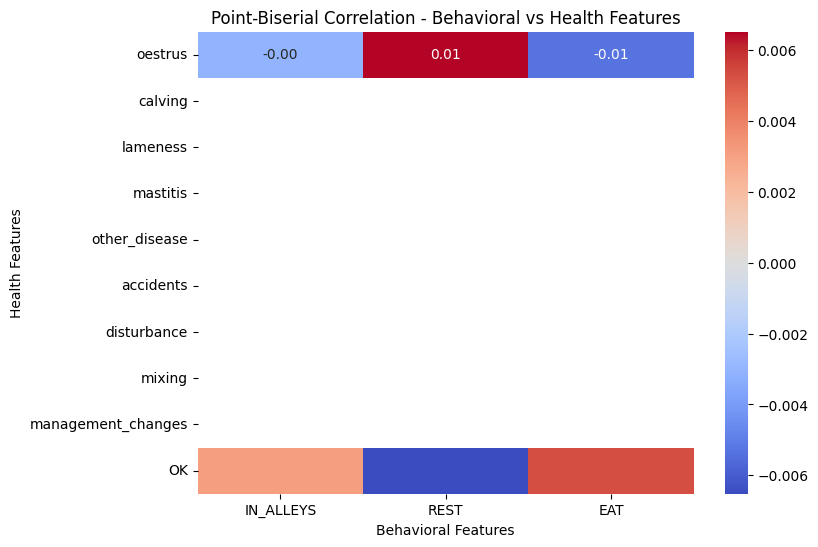


Point-Biserial Correlation Plot:


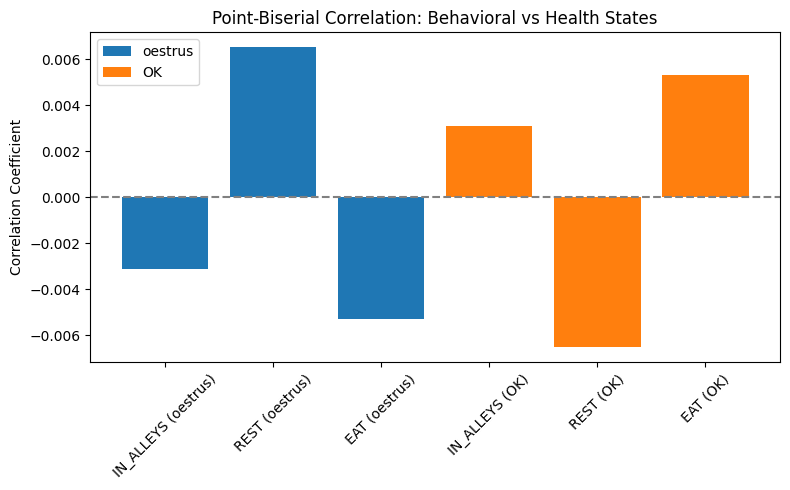


Phi Correlation:


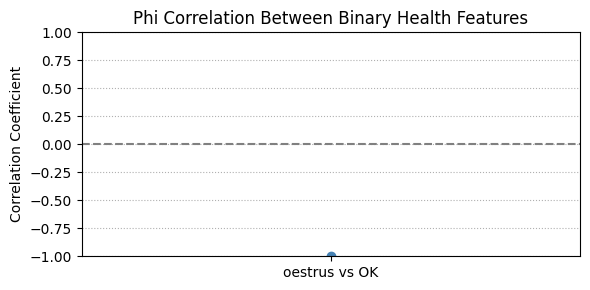


Analyzing C:/Users/lamia/Desktop/datasets/truncated_dataset4.csv

Dataset First View:

Dataset Rows & Columns count:
Number of rows are:  200000
Number of columns are:  19

Column Names:
Index(['cow', 'date', 'hour', 'IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL',
       'oestrus', 'calving', 'lameness', 'mastitis', 'LPS', 'acidosis',
       'other_disease', 'accidents', 'disturbance', 'mixing',
       'management_changes', 'OK'],
      dtype='object')

Distribution of Health States:


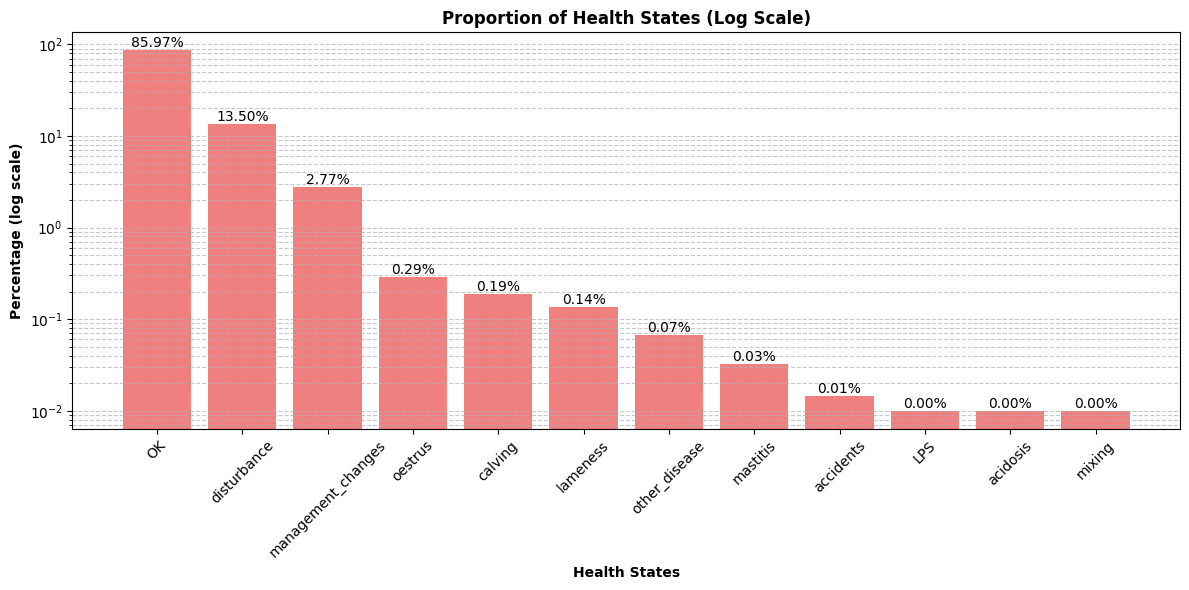


Unique Value Counts per Event:
Unique Value Counts per Event:
oestrus:
oestrus
0    199429
1       571
Name: count, dtype: int64
---------------------------------
calving:
calving
0    199626
1       374
Name: count, dtype: int64
---------------------------------
lameness:
lameness
0    199726
1       274
Name: count, dtype: int64
---------------------------------
mastitis:
mastitis
0    199935
1        65
Name: count, dtype: int64
---------------------------------
LPS:
Series([], Name: count, dtype: int64)
---------------------------------
acidosis:
Series([], Name: count, dtype: int64)
---------------------------------
other_disease:
other_disease
0    199867
1       133
Name: count, dtype: int64
---------------------------------
accidents:
accidents
0    199971
1        29
Name: count, dtype: int64
---------------------------------
disturbance:
disturbance
0    172997
1     27003
Name: count, dtype: int64
---------------------------------
mixing:
mixing
0    200000
Name: count, dty

<Figure size 1500x800 with 0 Axes>

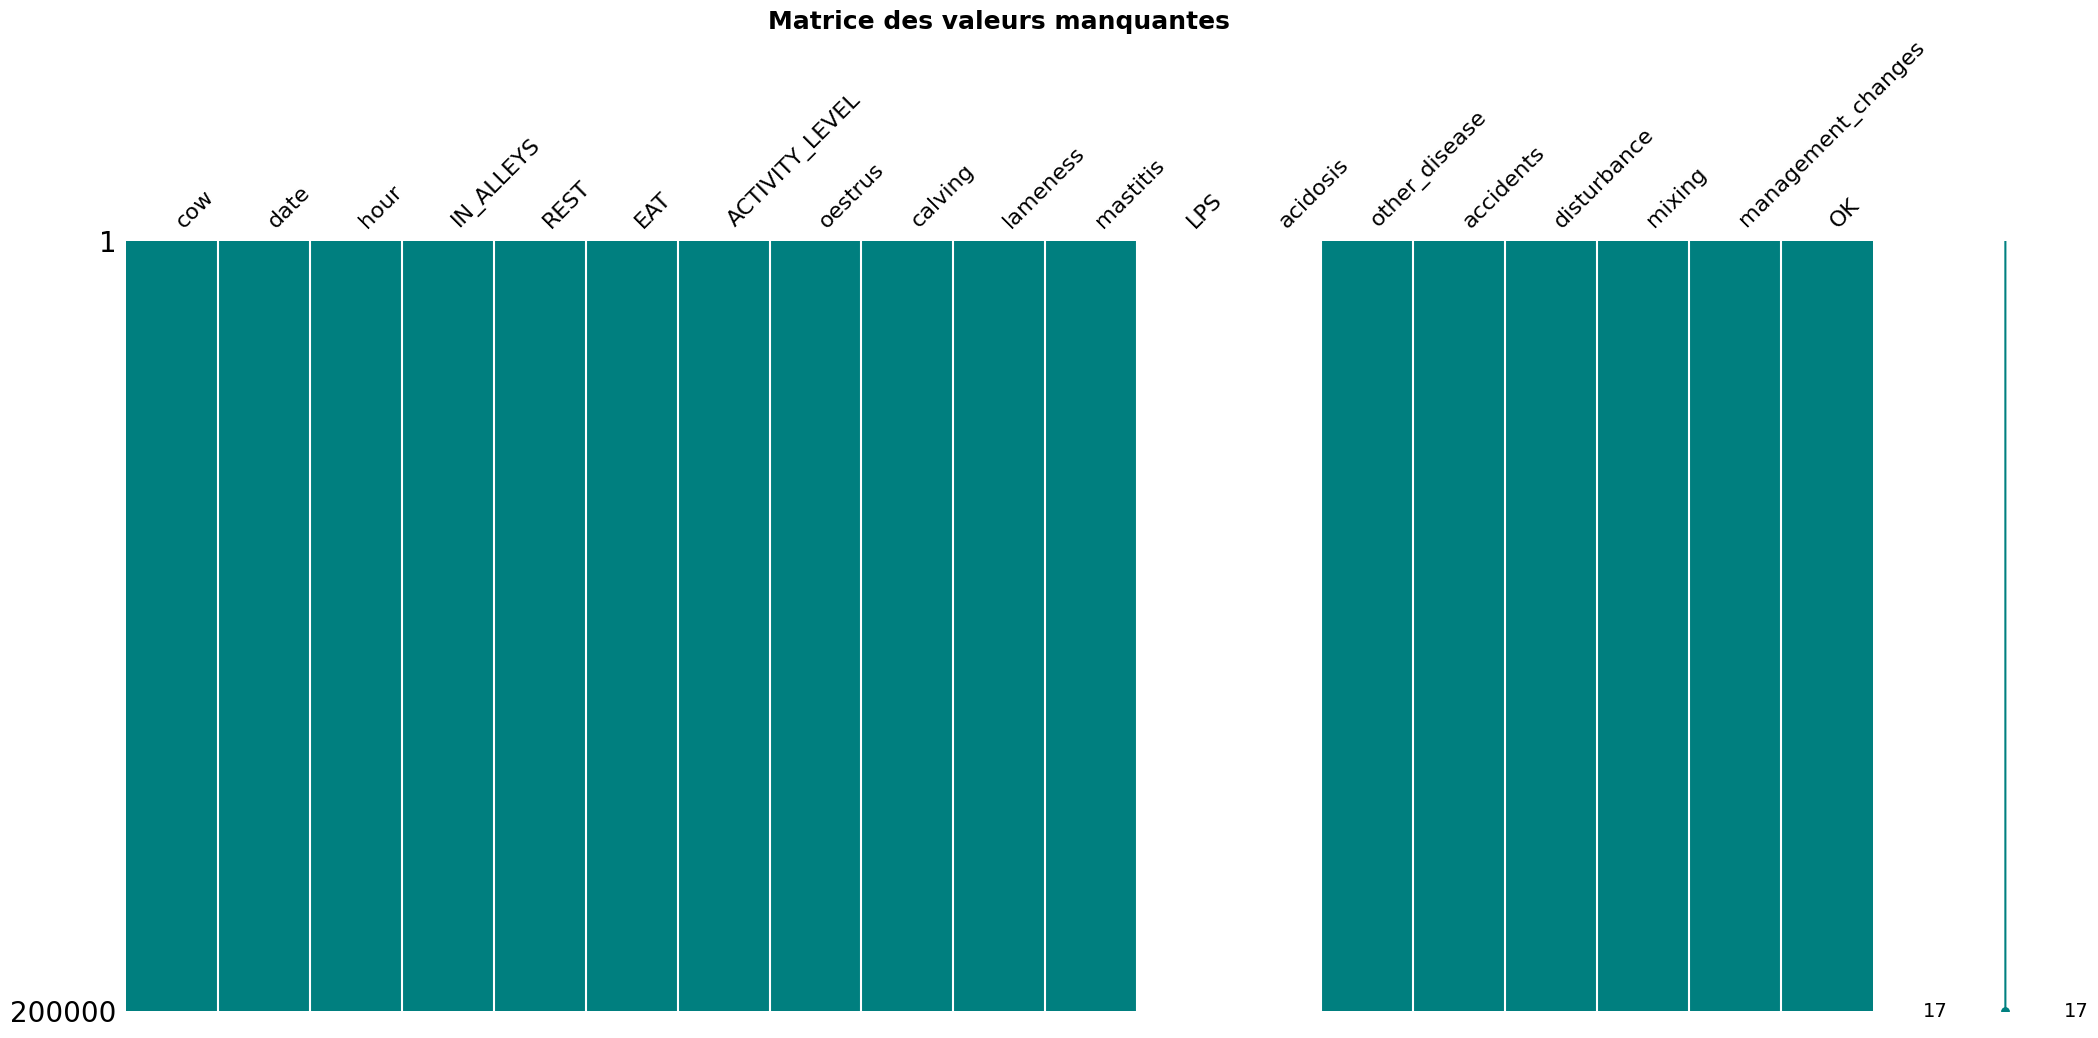


Outliers Detection:
Plage théorique : [-828, 1512]
Plage observée  : [-828.00, 1512.00]


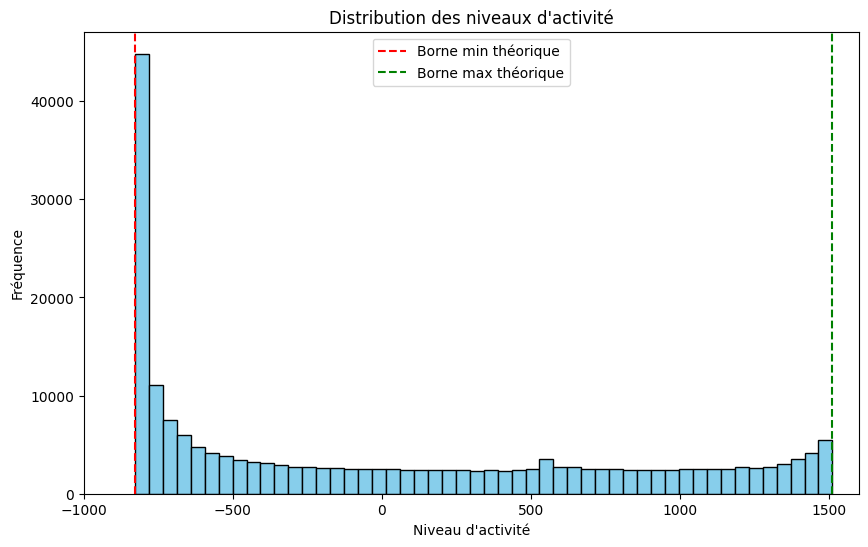


[ Rapport d'anomalies ]
- Valeurs hors plage théorique : 0 (0.00% du dataset)
- Aucune valeur hors plage détectée.

Data Distribution Histograms:


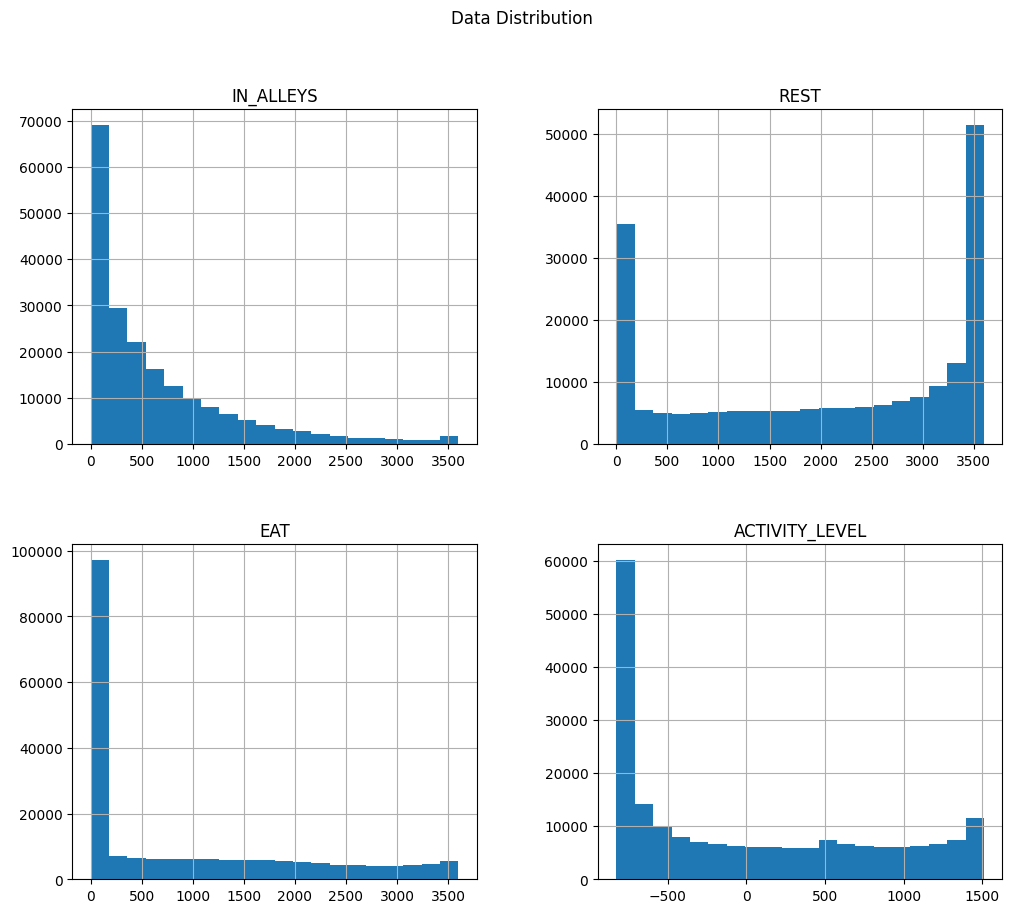


Health States Proportions:


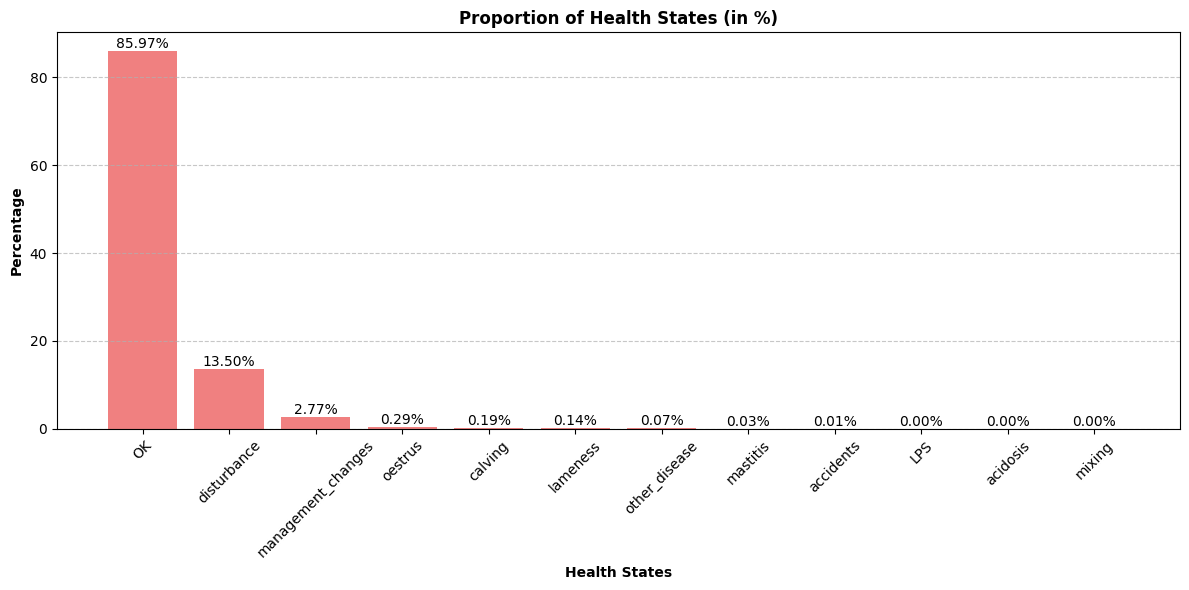


Missing Hours:


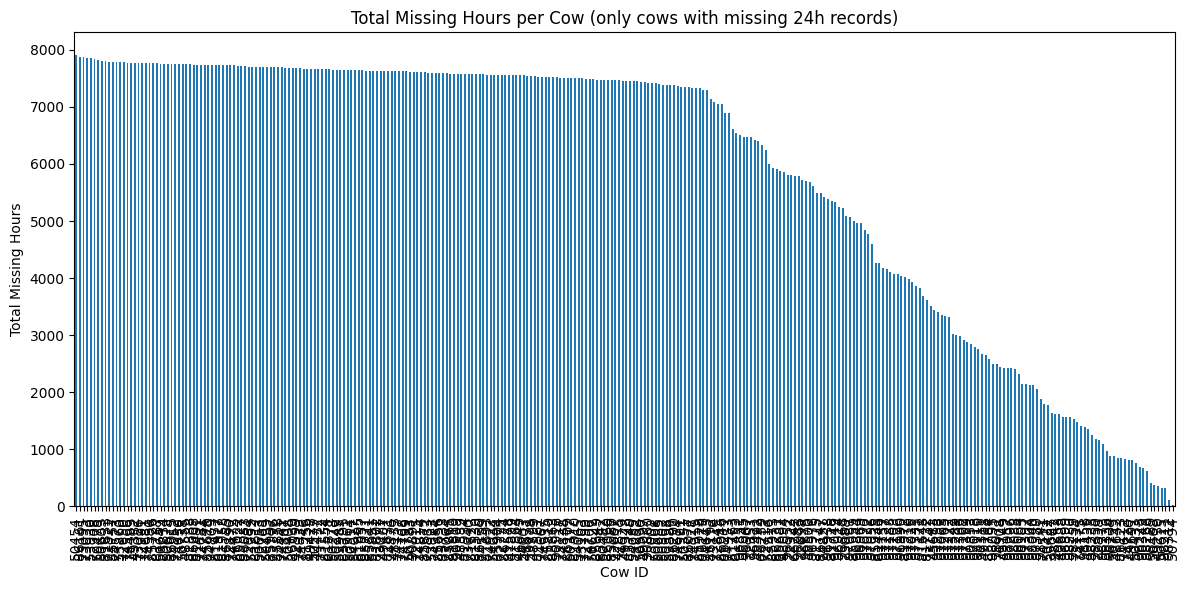


Date Range and Missing Dates:
Date range: 2014-12-01 00:00:00 to 2015-12-31 00:00:00
Total expected days: 396

Missing dates 2: 2015-07-05, 2015-07-06

Analysis of Cows with Multiple Diseases:
Number of cases with multiple diseases: 419
          cow       date  hour             maladies_presentes
211     50590 2015-10-16    14        [lameness, disturbance]
238     86053 2015-08-01     1        [lameness, disturbance]
613     97171 2015-07-10    12        [lameness, disturbance]
877     74939 2015-06-16    18  [calving, management_changes]
1785    98095 2015-09-03    13        [lameness, disturbance]
...       ...        ...   ...                            ...
197412  81833 2015-09-24    10       [calving, other_disease]
197475  90860 2015-11-20    20         [calving, disturbance]
198139  97272 2015-09-14    19         [oestrus, disturbance]
199009  74528 2015-07-01     9        [lameness, disturbance]
199313  98141 2015-11-28     4         [oestrus, disturbance]

[419 rows x 4 col

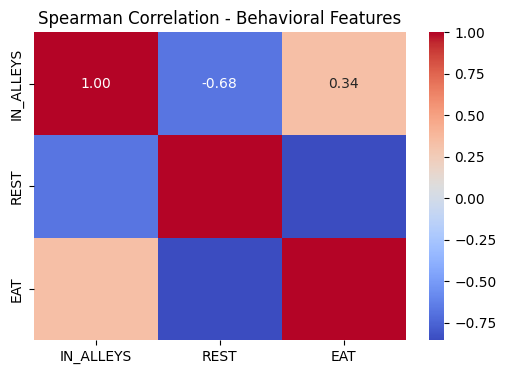

c:\Users\lamia\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


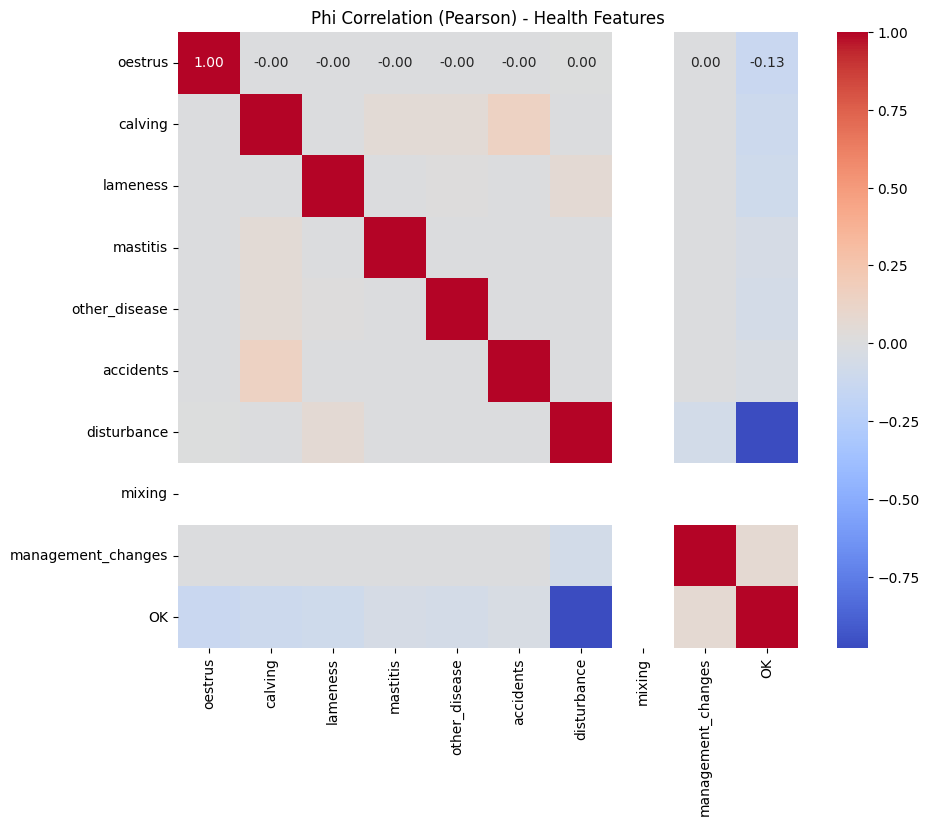

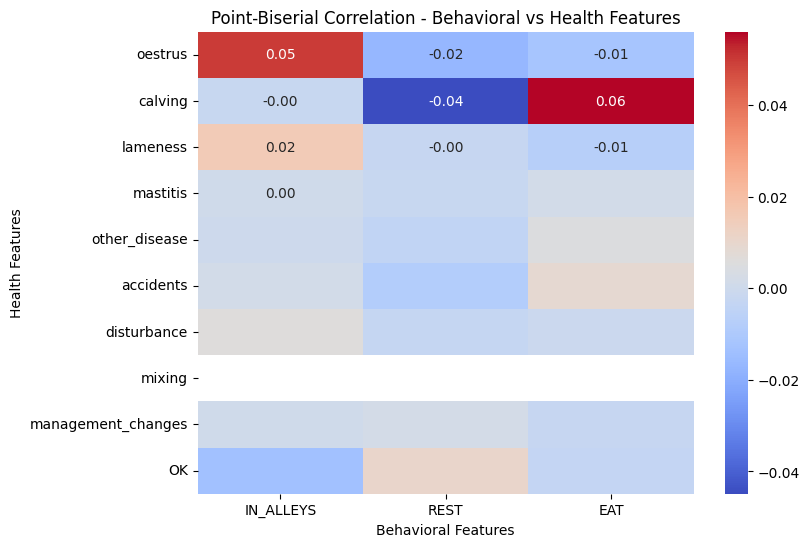


Point-Biserial Correlation Plot:


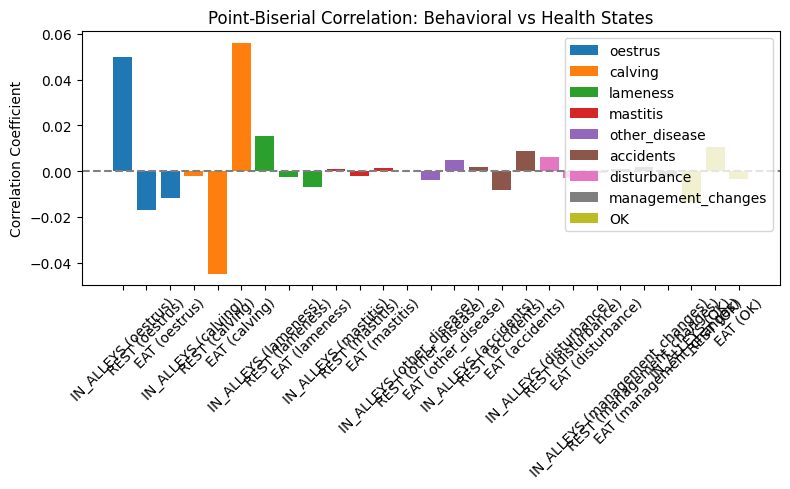


Phi Correlation:


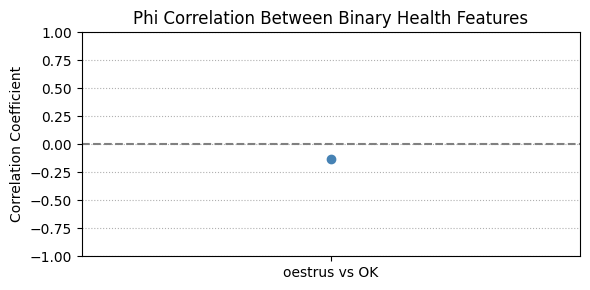

In [32]:

datasets = [r"C:/Users/lamia/Desktop/datasets/dataset1.csv","C:/Users/lamia/Desktop/datasets/dataset2.csv","C:/Users/lamia/Desktop/datasets/dataset3.csv", "C:/Users/lamia/Desktop/datasets/truncated_dataset4.csv"]  
# datasets = [r"C:/Users/lamia/Desktop/datasets/dataset1.csv"]  

for file_path in datasets:
    print(f"\nAnalyzing {file_path}")
    df = load_dataset(file_path)
    print("\nDataset First View:")
    display_dataset_head(df)
    print("\nDataset Rows & Columns count:")
    print_dataset_shape(df)
    print("\nColumn Names:")
    display_column_names(df)
    behavioral_features, health_indicators = define_features(df)
    print("\nDistribution of Health States:")
    plot_health_states_distribution(df)
    print("\nUnique Value Counts per Event:")
    print_unique_value_counts(df)
    print("\nNumber of Unique Cows:")
    count_unique_cows(df)
    print("\nCow IDs:")
    display_cow_ids(df)
    print("\nDuplicate Values:")
    check_duplicates(df)
    print("\nMissing Values:")
    print(check_missing_values(df))
    print("\nMatrix of Missing Values:")
    plot_missing_values_matrix(file_path)
    print("\nOutliers Detection:")
    detect_and_plot_outliers(df)
    print("\nData Distribution Histograms:")
    plot_histograms(df)
    print("\nHealth States Proportions:")
    plot_health_states_proportions(file_path)
    print("\nMissing Hours:")
    plot_missing_hours(file_path)
    print("\nDate Range and Missing Dates:")
    check_date_range(df)
    print("\nAnalysis of Cows with Multiple Diseases:")
    analyze_multiple_diseases(df)
    print("\nOK Label Consistency Check:")
    check_ok_label_consistency(df)
    print("\nCorrelation Analysis:")
    perform_correlation_analysis(df)
    print("\nPoint-Biserial Correlation Plot:")
    plot_point_biserial_correlation(df)
    print("\nPhi Correlation:")
    plot_phi_correlation(df)